$$\Huge\textbf{Digital image processing of solar images}$$

Module name is $\textit{dipsi}.$

It's short for Digital Image Processing of Solar Images. Dipsi includes functions for limb darkening removal, non-radial variation removal, solar feature detection with probability of detection and so on. With its different approach based on the probability classification this module presents substitution for already existing solar image segmentation algorithms.

You are welcome to use it, all of it is free and accessible as it can be or as could be regarding to my abilities.

$\large\textbf{Used libraries}$

In [30]:
from PIL import Image
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
#from skimage import measure
from skimage.filters import median
from skimage.filters.rank import mean
from skimage.morphology import disk, square, diamond
from scipy.optimize import curve_fit
import statistics # je potřeba kde??? Možná medián seznamu?
import polarTransform
from skimage.util import img_as_int, img_as_bool
from skimage.feature import canny #for Hough transform
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse #for Hough transform
from skimage.draw import circle_perimeter, ellipse_perimeter #for  Hugh transform
from skimage.filters import threshold_otsu, sobel #for non-radial variation removal
from scipy import ndimage
from skimage.measure import regionprops_table
import pandas as pd
import timeit #pro měření času potřebného pro běh funkcí/kódu
%matplotlib inline

$\large\textbf{Image loading}$

Upravit tak, aby to byla funkce, která pozná typ snímku a podle toho ho otevře (tj. pozná zda je to fits, jpg, png..)

In [4]:
#loading of image series (Python pro fyziky)
def image_loading(image, file_format='fits'):
    """ 
    Load image according its format. In long term should return image series..
    
    Here comes more detailed description - some day...
    
    Parameters
    ----------
    image: string
        Path to the file where required image is stored.
        
    file_format: {'fits', 'jpg', 'png', 'tiff'}, default is 'fits'
        Format of the image to be opened. If not given, fits/fts file 
        as most common astronomical format is presumed.
    
    Returns
    -------
    sol_img: ndarray
        Input image as an ndarray.
    
    Notes
    -----
    ???
    
    Example
    -------
    ???
    
    """
    if file_format == 'fits':
        sol_img = np.asarray(fits.getdata(image)) # načtení fits dat pomocí knihovny astropy
    else:
        sol_img = np.asarray(Image.open(image).convert('L'))[::-1] # Image otvírá jpg, png, tiff
    
    # přetypování snímku z unsign integer uint16: 0 to 65535 na int: -32768 to 32767
    #sol_img = sol_img.astype('int16') 
    #asi lepší: 
    sol_img = img_as_int(sol_img) #tuto část promyslet, abych nemusel uint měnit na int 

    return sol_img #sol_img_name, sol_img_filter (CA, HALPHA, CONTINUUM)

In [4]:
# Zde funkci, která vykopne informace o snímku, které budou potřeba dále. Jednak datum a čas pozorování (potřeba
# při převodu do heliografických souřadnic) a jednak pozorovací kanál (bílé světlo, H alfa nebo vápník?)
# Pozorovací kanál nejspíše tak, že uživatel musí zadat, z jaké observatoře data použil a následně funkce 
# rozklíčuje název snímku podle pojmenovávání dané observatoře (jestli observatoř použivá v názvu snímku informaci
# o pozorovacím kanálu!!!)
#Nebo rovnou do funkce načítání snímku!!!

In [5]:
# Funkce show_image a show_images jsou především pro mé vnitřní použití - mezivýsledky, příp. srovnání před a po
def show_image(image):
    """
    Display given image and return nothing.
    
    Parameters
    ----------
    image: ndarray
        Input image.
    
    """
    print('Image type: ', type(image), ', Image shape: ', image.shape, ', Image data type: ', image.dtype)
    plt.rcParams['figure.figsize'] = [10, 10] # nastavení velikosti okna, které zobrazuje snímek
    plt.imshow(image, cmap="gray",origin='lower') # zobrazení snímku, 'lower' place [0,0] in lower left corner

    
def show_images(image1, image2):
    """
    Just display two given loaded images and return nothing.
    
    Parameters
    ----------
    image1: ndarray
        Input image.
    image2: ndarray
        Second input image.
    
    """
    print('Image1 type: ', type(image1), ', Image1 shape: ', image1.shape, ', Image1 data type: ', image1.dtype)
    print('Image2 type: ', type(image2), ', Image2 shape: ', image2.shape, ', Image2 data type: ', image2.dtype)
    plt.rcParams['figure.figsize'] = [15, 15]
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap=plt.cm.gray, origin='lower')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap="gray", origin='lower')
    plt.axis('off')
    plt.show()


/home/bara/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:479: UserWarning: Downcasting uint16 to int16 without scaling because max value 1080 fits in int16
  return convert(image, np.int16, force_copy)


Image type:  <class 'numpy.ndarray'> , Image shape:  (2048, 2048) , Image data type:  int16


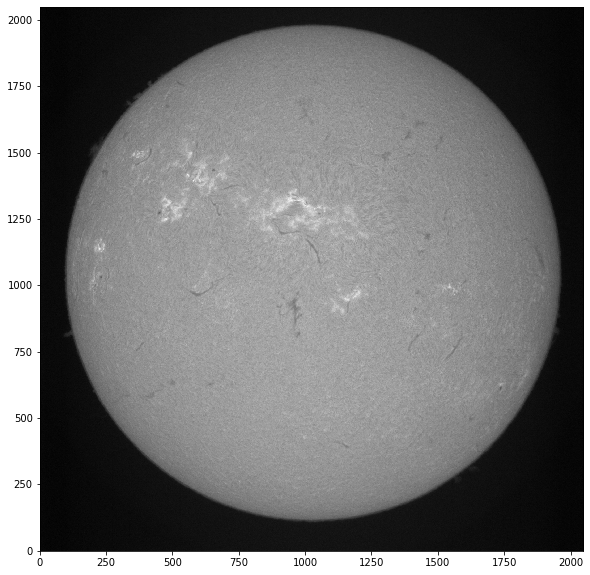

In [6]:
sol_img = image_loading('images/chromo/kanz_halph_fi_20150607_062023.fts') #přidat filtr, který zadá uživatel
show_image(sol_img)

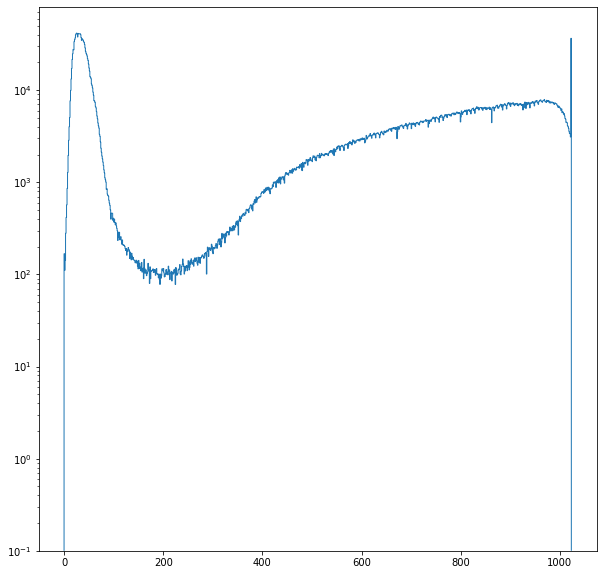

In [6]:
# zobrazení histogramu pomocí knihovny matplotlib
min_val = np.amin(np.amin(sol_img))
max_val = np.amax(np.amax(sol_img))
histogram = plt.hist(sol_img.flatten(), histtype='step', bins=int(max_val) - int(min_val), log=True)

$\large\textbf{Reducing image size (for median filter, using PIL)}$

In [6]:
# upravit tak, aby funkce byla použitelná i na zvětšení zpět? Nebo napsat druhou funkci OriginalImageSize()?
# zjistit velikosti snímků z observatoří, jež chci používat, aby zmenšený nebyl pak příliš malý!
def size_reduction(image, reduction_coefficient): #pridat parametr něco jako koeficient zmenšení kvůli Hough
    """
    Reduce image size with reduction_coefficient. Or magnify if reduction_coefficient is given as a fraction.
    
    Parameters
    ----------
    image: ndarray
        Input image.
    reduction_coefficient: integer
        Factor used to reduce image shape.
        
     Returns
    -------
    sol_img_small: ndarray
        Output reduced image.
        
    """
    # požadované rozměry zmenšeného obrazu, zmenšuji na čtvrtinu, protože funkce resize z Image transponuje, 
    #musím obrátit pořadí width a height, tj. image.shape[1] je ve skutečnosti height:
    width = int(image.shape[1]/reduction_coefficient)
    height = int(image.shape[0]/reduction_coefficient)
    
    sol_img_small = np.array(Image.fromarray(image).resize((width, height), Image.BILINEAR)) # bilinear, bikubic?
        
    return sol_img_small

Image type:  <class 'numpy.ndarray'> , Image shape:  (512, 512) , Image data type:  int32


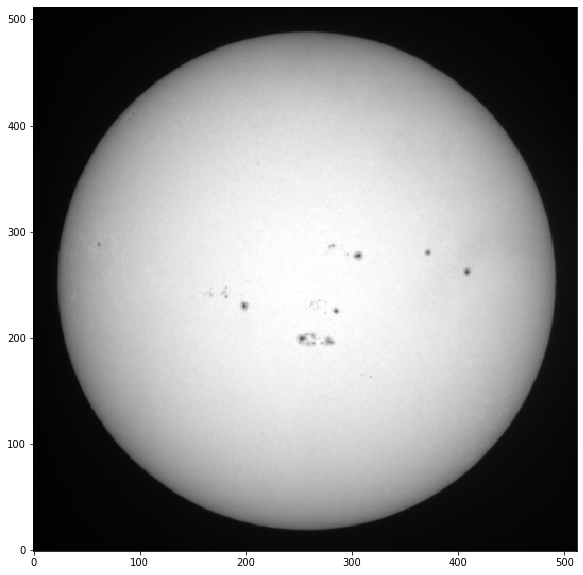

In [8]:
sol_img_small = size_reduction(sol_img, 4)
show_image(sol_img_small)

$\large\textbf{Hough transform: circle}$

Postupuji podle příkladu v skimage.

In [7]:
def circle_hough_transform(image):
    """
    Perform a circle hough transform on the input image.
    
    Parameters
    ----------
    image: ndarray
        Input image.
        
    Returns
    -------
    edges: array
        The binary edge map obtained with Sobel filter.
    cx: integer
        X-coordinate of solar disc center.
    cy: integer
        Y-coordinate od solar disc center.
    radii: integer
        Radius of solar disc.
        
    """
    image_for_otsu = np.copy(image)
    thresh = threshold_otsu(image)      
    image_for_otsu = image > thresh #binary image created  
    edges = sobel(image_for_otsu) #finding edges using Sobel filter
   
    #hodně kroků, asi zmenšit jen jednou a zmenšovacím koeficientem zvětšit výsledký poloměr a to už pustit na image
    radius_estimation = min(image.shape) / 2
    #print('First estimation of radius as a half of the smaller value from image shape: ', radius_estimation)
    
    #nejspíše není třeba cyklu, původně jsem zmenšovala 5x, pak 2x a teď jen jednou a výsledek stejný...
    for i in range(10, 0, -5):
        #small_image = size_reduction(image_for_otsu, i)
        small_edges = size_reduction (edges, i)
        estimated_val = radius_estimation/i
        hough_radius = np.arange(estimated_val - 10, estimated_val + 10, 1) #určení rozsahu, v kterém hledáme poloměr
        hough_res = hough_circle(small_edges, hough_radius) #akumulátor pro všechny nalezené poloměry a středy cx, cy
        accums, cx, cy, radius = hough_circle_peaks(hough_res, hough_radius, total_num_peaks=1)
        #print("Radius in each step: ", radius)
        radius_estimation = int(radius)*i
        #print('Computed radius for each step: ', radius_estimation)
        
    hough_radius = np.arange(radius_estimation - 10, radius_estimation + 10, 1)
    hough_res = hough_circle(edges, hough_radius)
    accums, cx, cy, radius = hough_circle_peaks(hough_res, hough_radius, total_num_peaks=1)  

    return edges, int(cx), int(cy), int(radius)

In [8]:
def draw_hough_result(image, hough_res):
    """
    Draw results of hough transform - binary edge map and calculated circle or ellipse (according 
    given information) which is drawn into the solar image. Return nothing.
    
    Parameters
    ----------
    image: ndarray
        Input image.
    houg_res: array
        Contain binary edge map, coordinates of solar disc center and solar disc radius in case of
        the circle. Binary edge map, center coordinates, semi-major axis, semi-minor axis and 
        orientation in case of the ellipse.
        
    """
    if len(hough_res) > 4:
        edges, xc, yc, a, b, orientation = hough_res
        image_hough_edge=np.copy(image)
        cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
        image_hough_edge[cy, cx] = np.amax(image) + 1000 

    else:
        edges, cx, cy, radius = hough_res
        image_hough_edge = np.copy(image) #vytvoření proměnné, do které vykreslíme nalezený sluneční okraj
        circy, circx = circle_perimeter(cy, cx, radius,shape=image_hough_edge.shape)
        #obarvení, resp. vyznačení kružnice tak, že si zjistím maximální hodnotu jasu v obrázku a přičtu třeba 1000
        image_hough_edge[circy, circx] = np.amax(image) + 1000 
    
    #vykreslení hranového snímku (canny) a řešení Houghovy transformace
    plt.rcParams['figure.figsize'] = [25, 25]
    plt.subplot(1, 2, 1)
    plt.imshow(edges, cmap=plt.cm.gray, origin='lower')
    plt.subplot(1, 2, 2)
    plt.imshow(image_hough_edge, cmap=plt.cm.gray, origin='lower')
    plt.show()

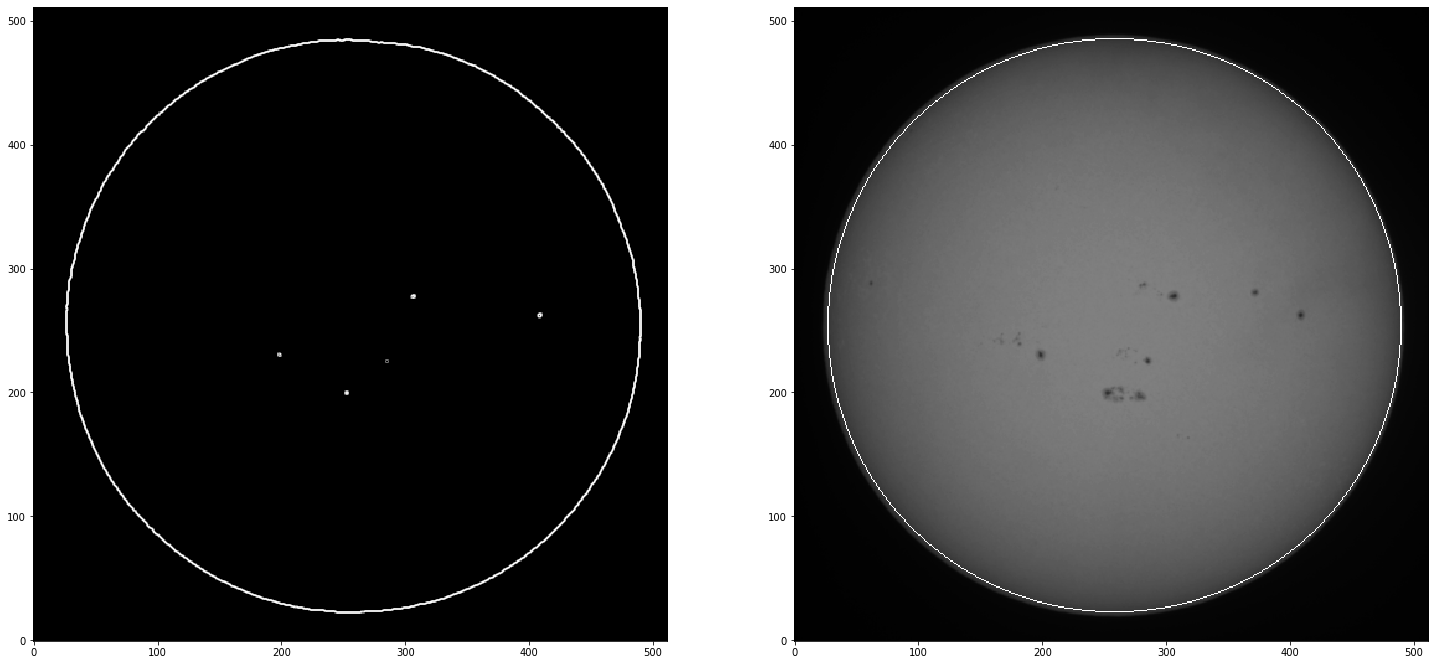

258 254 231


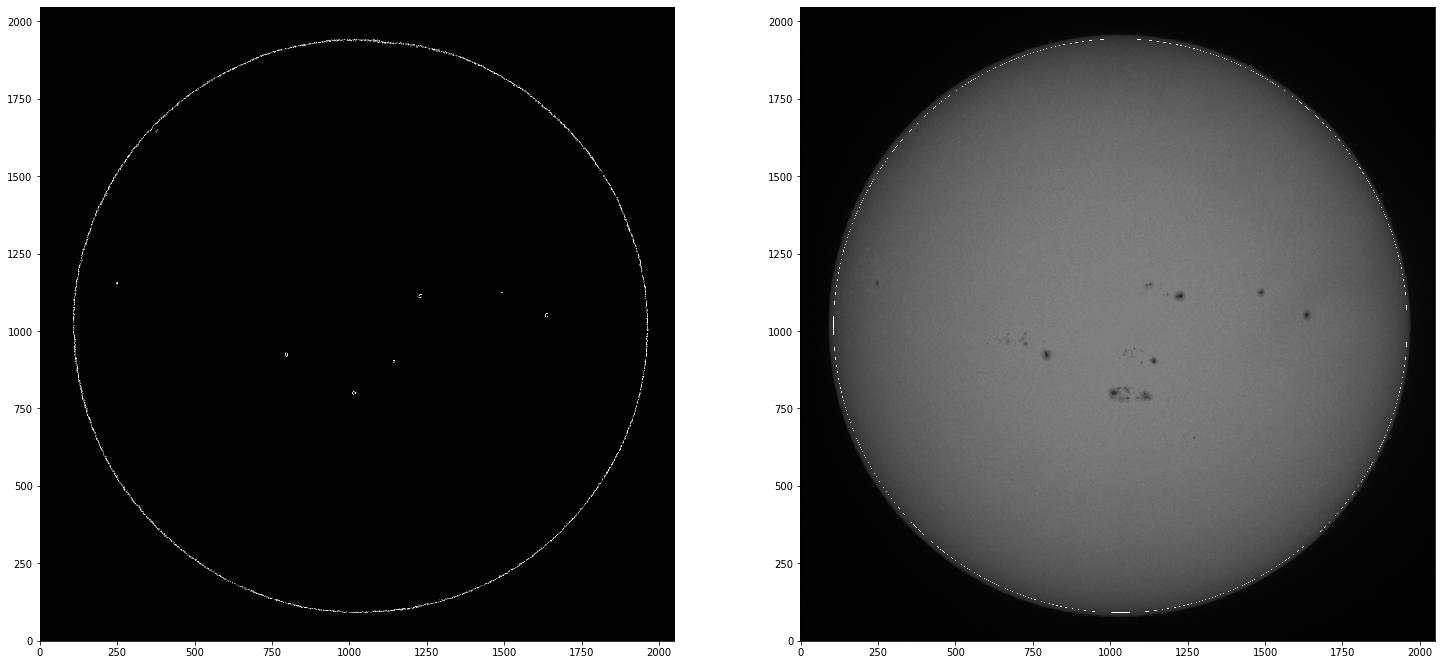

1033 1016 925


In [11]:
#Houghova transformace pro zmenšený snímek
hough_res = circle_hough_transform(sol_img_small)
hough_res_drawing = draw_hough_result(sol_img_small, hough_res)
edges, cx, cy, radius = hough_res #cx, cy určitě správně, ověřeno na obdélníkovém snímku (Hvězdárna Val.Meziříčí)
print(cx,cy,radius)

#Houghova transfromace a její výsledky pro snímek s původní velikostí, nefunguje dobře na sol_img, ale 
#na sol_img_nld_big ano, aspoň o KSO... ještě podívat, asi bych měla počíta na původním snímku
hough_res_big = circle_hough_transform(sol_img)
drawing_new = draw_hough_result(sol_img, hough_res_big)
edges_big, cx_big, cy_big, radius_big = hough_res_big 
print(cx_big,cy_big,radius_big)

$\large\textbf{Hough transform: ellipse}$

Postupuji podle příkladu v skimage. Je potřeba podstatně delší čas (cca 5 min), hledám 5 parametrů místo 3, jak tomu bylo u kružnice. Nefunguje na HVM.

def ellipse_hough_transform(image, circle_radius):
    """
    Perform an ellipse hough transform on the input image.
    
    Parameters
    ----------
    image: ndarray
        Input image.
    circle_radius: integer
        Radius calculated with circle_hough_transform function.
    
    Returns
    -------
    xc: integer
        X-coordinate of elliptical solar disc center.
    yc: integer
        Y-coordinate of elliptical solar disc center.
    a: integer
        Semi-major axis.
    b: integer
        Semi-minor axis.
    orientation: double
        Major axis orientation in clockwise direction as radians.
        
    """    
    # Perform a Hough Transform
    # The accuracy corresponds to the bin size of a major axis.
    # The value is chosen in order to get a single high accumulator.
    # The threshold eliminates low accumulators
    
    image_for_otsu = np.copy(image)
    thresh = threshold_otsu(image)
    image_for_otsu = image > thresh 
    edges = img_as_bool(sobel(image_for_otsu))

    #zkusit vzít výsledky kruhové hough transformace a použít pro zmenšení rozsahu min_size a max_size
    # spustit na zmenšený obrázek a pak postupně zvětšovat
    variance = int(circle_radius * (5/100)) #max variace as a 5% of radius from circle Hough transform
    
    min_ax = circle_radius - variance
    max_ax = circle_radius + variance
    
    #result obsahuje mnoho šestic, každá šestice je (max_hist = accumulator, yc, xc, a, b, orientation)
    #accuracy: bin_size = accuracy * accuracy! Musí být dostatek binů
    result = hough_ellipse(edges, accuracy=25, threshold=250, min_size=min_ax, max_size=max_ax)
    result.sort(order='accumulator') #accumulator je hodnota každá 'max_hist' větší jak threshold

    # Estimated parameters for the ellipse
    best = list(result[-1]) #vypisuje chybu pro jeden snímek s erupcemi, prostudovat si tuto část a opravit!!!
    yc, xc, a, b = [int(round(x)) for x in best[1:5]]
    orientation = best[5]
   
    return edges, xc, yc, a, b, orientation

#štvát jen na malý snímek, ten pak upravit na kruh a z takovéh snímku až počítat i velký poloměr
#elipsa bude vždycky trvat dlouho! Čím větší snímek, tím hůř...
hough_res_el = ellipse_hough_transform(sol_img_small, 232) 

hough_res_drawing = draw_hough_result(sol_img_small, hough_res_el)

print('xc, yc, a, b, orientation: ', hough_res_el[1], hough_res_el[2], hough_res_el[3], hough_res_el[4], 
      hough_res_el[5])

In [12]:
#Compute ellipse hough transform time
#def ellipse_hough_time():
    
#    ellipse_hough_transform(sol_img_small, radius)
  
   
#print(timeit.timeit("ellipse_hough_time()", setup="from __main__ import  ellipse_hough_time"), number=10)

$\large\textbf{Resampling of elliptical solar disc to circular shape}$

In [13]:
#Zde prijde kus kódu pro transfromaci eliptickeho slunečního disku na kruhový
#if a =! b than resample to cirkular shape, resp. if |a-b| > přípustná odchylka pár pixelů (procentuálně z velikosti
# obrázku)

$\large\textbf{Získání aritmetického průměru ze slunečního disku, často používaná hodnota}$

In [9]:
def get_mean(image, radius, center):
    """
    Calculate mean value from given (supposedly solar) disc and creates constant array from this value.
    
    Parameters
    ----------
    image: ndarray
        Image containing disc from which arithmetic mean calculation is required.
    radius: integer
        Solar disc radius expected.
    center: list with only two values
        Solar disc center coordinates expected.
    
    Returns
    -------
    mean_img: array
        Return constant array (filled with one value calculeted as a arithmetic mean from 
        given disc - solar disc, median mask, limb darkening mask etc.).
    
    """
    cx, cy  = center
    width, height = image.shape
    data_for_mean = []
    for x in range(0, width):
        for y in range(0, height):
            if (cx - x)**2 + (cy - y)**2 <= (radius - 40)**2:
                data_for_mean.append(image[y,x])
    
    #nevracet pole, ale jen jednu hodnotu a pak kde potřebuju pole, přidám np.full(GetMean...)
    return np.full(image.shape, np.round(sum(data_for_mean) / len(data_for_mean))) 
#return np.full(image.shape, np.round(sum(sum(image)) / (image.shape[0]*image.shape[1])))

In [13]:
mean_array = get_mean(sol_img_small, radius, [cx, cy])
print(mean_array.shape, mean_array[0][0])

(512, 512) 887.0


$\large\textbf{Image defects detection}$

In [14]:
#def image_defects_controller(image, a, b): #a, b poloosy elipsy
    #kontrola kvadrantů, když je jeden výrazně jiný než ostatní, pak chyba č. 1
#    if ... :
#        num = 1 
    #deformovaný snímek (kontrola poloos, moc jiné, pak chyba č. 2)
#    if ... :
#        num = 2 
    #zdá-li se vše být OK
#    else:
#        num = 0 
#    return 
    

$\large\textbf{Limb darkening removal}$

S použitím Houghovy transformace. Snímek převedu z kartézských do polárních souřadnic za pomoci výsledků z Houghovy transformace. Dostanu obrázek, kde vertikální osa bude r, horizontální bude fí. Vypočtu medián každého řádku (to jest podél konstantního r), uložím do seznamu. Fituji tento seznam vhodným polynomem, abych našla funkční závislost pro okrajové ztemnění. Vytvořím masku. Vydělím snímek maskou. Vynásobím vhodným faktorem pro upravení hodnoty intenzity pozadí.

$\textbf{Transformation from cartesian to polar coordinates, mapped onto a rectangular grid}$

In [10]:
#Převod do polárních souřadnic pomocí polarTransform, defaultně bikubická, lze změnit
def transform_to_polar(image, hough_res):
    """
    Transform solar image from cartesian coordinates to polar coordinates. 
    
    Parameters
    ----------
    image: ndarray
        Input image.
    hough_res: array 
        Contain  results from circle hough transform. Image edge map, 
        coordinates x and y of solar disc center and solar disc radius.
        
    Returns
    -------
    warped: ndarray
        Solar disc from input image in polar coordinates.
        
    """
    edges, cx, cy, radius = hough_res
    warped = (polarTransform.convertToPolarImage(image, center=(int(cx), int(cy)), finalRadius=int(radius), 
                                                 radiusSize=int(radius), angleSize=360))[0].T
    
    return warped

Image type:  <class 'numpy.ndarray'> , Image shape:  (231, 360) , Image data type:  int32


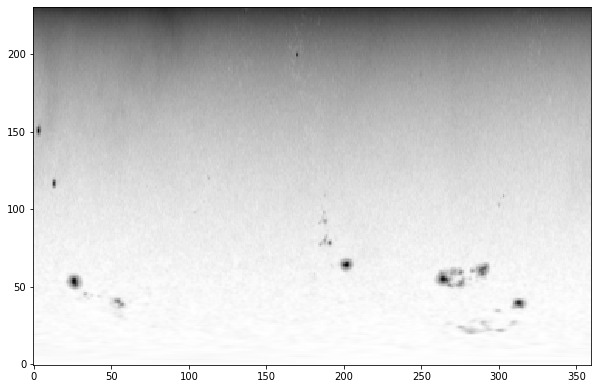

In [16]:
polar_img = transform_to_polar(sol_img_small, hough_res)
show_image(polar_img)

$\textbf{Median of each row corresponding to polar coordinate r saved as list_of_medians}$

In [11]:
#odříznout body ve středu či málo husté oblasti, resp. v následujícím fitovat jen od určité vzdálenosti od středu
def median_of_rows(polar_image):
    """
    Compute median of each row from input image.
    
    Parameters
    ----------
    polar_image: ndarray
        Image of solar disc in polar coordinates.
        
    Returns
    -------
    list_of_medians: list
        Each value in the list represent median of corresponding row.
        
    """    
    #rectangular image after transformation to polar coordinates required
    list_of_medians=[]
    for row in polar_image:
        #if 
        list_of_medians.append(statistics.median(row))
    
    return list_of_medians

<class 'list'>


Text(0.5, 1.0, 'Průběh okrajového ztemnění')

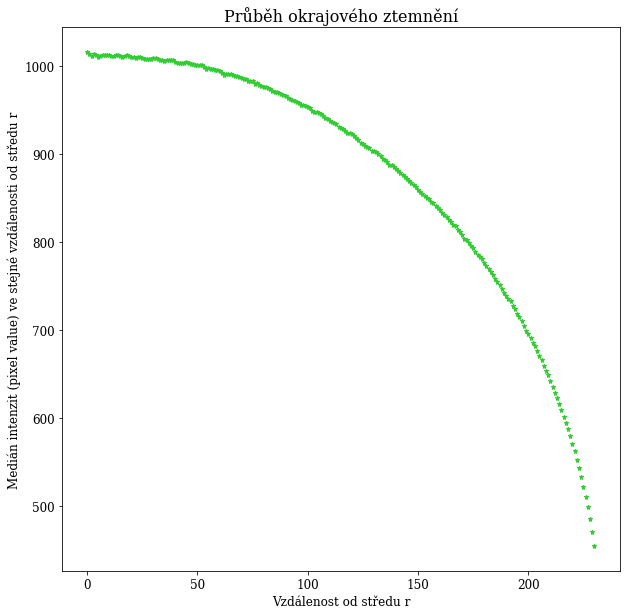

In [18]:
list_of_medians = median_of_rows(polar_img)
print(type(list_of_medians))
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size']=12
plt.rcParams['font.family'] = ['Serif']
plt.plot(list_of_medians, '*', color='limegreen', markersize=5)
plt.xlabel('Vzdálenost od středu r')
plt.ylabel('Medián intenzit (pixel value) ve stejné vzdálenosti od středu r')
plt.title('Průběh okrajového ztemnění', fontsize=16)

$\textbf{Fitting of list_of_medians by low-order polynomial function - limb darkening function}$

In [52]:
#fit pomocí metody nejmenších čtverců
#rozdělit asi na tři funkce, jednak získání dat, jednak func a jednak vypočtení fitu
def data_for_fit(list_of_medians, radius):
    
    #nastavit omezení relativně!!! čili nezačínat pevně od 50 pixelů do r-10, co když je to snímek 64 x 64? :-D
    #hodnoty od cca 50 po poloměr disku (radii - cca 10), tj. max délka list_of_medians krom středové oblasti a limbu
    x_data = np.arange(int(0.15*radius), len(list_of_medians)-int(0.015*radius), 1) 
    max_value = max(list_of_medians)
    y_data = list_of_medians[int(0.15*radius):len(list_of_medians)-int(0.015*radius)]

    return max_value, x_data, y_data

#Zadefinování funkce popisující okrajové ztemnění, podle článku Solar Limb Darkening(Bayley, Boogert) z r. 2015
#Je třeba namapovat konstanty a0, a1, a2 od 0 po 1! bacha na jednotky!
def fit_function(x, a0, a1, a2, radius):
    
    #R = len(list_of_medians)
    mi = np.sqrt(1 - (x / radius)**2)
    return a0 + a1 * mi + 2* a2 * mi**2

def limb_darkening_fit(fit_function, x_data, y_data, list_of_medians):
    
    #Vypočtení vhodného fitu a jeho vykreslení
    popt, pcov = curve_fit(fit_function, x_data, y_data)
    print(popt)
    
    #vyhodit kreslící věci jinam
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.rcParams['font.size']=12
    plt.rcParams['font.family'] = ['Serif']
    plt.plot(list_of_medians, '*', color='limegreen', markersize=5)
    plt.plot(x_data, fit_function(x_data, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % popt)
    plt.xlabel('Vzdálenost od středu r')
    plt.ylabel('Medián intenzit pixelů ve stejné vzdálenosti od středu r')    
    plt.title('Průběh okrajového ztemnění proložený fitovací funkcí', fontsize=16)
    
    return popt

In [40]:
ld_fit = limb_darkening_fit(fit_function, data_for_fit(list_of_medians, radius)[1], data_for_fit(list_of_medians, radius)[2], list_of_medians)

NameError: name 'list_of_medians' is not defined

Image type:  <class 'numpy.ndarray'> , Image shape:  (231, 360) , Image data type:  float64


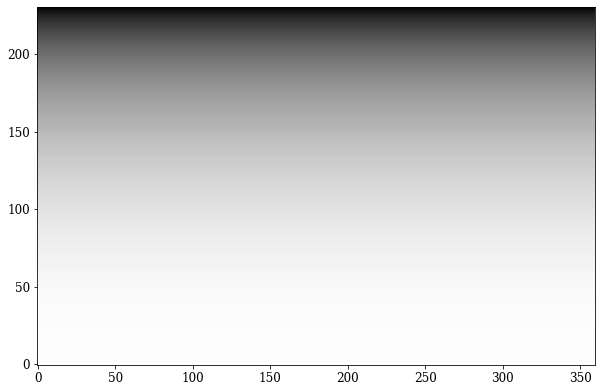

In [21]:
# Vytvoření masky pomocí list_of_medians: každou hodnotu roztáhnout na jeden řádek (pro srovnání s maskou z fitu)
# lze vidět, proč je třeba vynechat středovou oblast, značně ji narušuje, vyskytuje-li se zde pláž
# zde je jen pro srovnání s maskou z fitu, nepoužije se již nikde dále
medians_mask = np.repeat(list_of_medians, polar_img.shape[1]).reshape(polar_img.shape)
show_image(medians_mask)

In [13]:
#vytvoření masky za pomocí funkce okrajového ztemnění s výsledky metody nejmenších čtverců (tato dále použita)
def limb_darkening_mask_calculation(each_row_median_list, popt, polar_image_size):
    """
    Create limb darkening mask from limb darkening fit. 
    
    Parameters
    ----------
        list_of_medians: list
            Each value in the list represent median of corresponding row.
        popt: ndarray
            Three constants - results of limb darkening fit. 
        polar_image_size: tuple of two integer values 
            Shape of solar image in polar coordinates.
    
    Returns
    -------
    polar_fit_mask: ndarray
        Limb darkening mask computed from limb darkening function, still in polar 
        coordinates.
    
    """
    #x, y = polar_image_size
    a, b, c = popt
    medians_fit_values = fit_function(np.arange(0.0, len(each_row_median_list), 1), a, b, c)
    print(type(medians_fit_values))
    polar_fit_mask = np.repeat(medians_fit_values, polar_image_size[1]).reshape(polar_image_size)
    
    return polar_fit_mask

<class 'numpy.ndarray'>
Image type:  <class 'numpy.ndarray'> , Image shape:  (231, 360) , Image data type:  float64


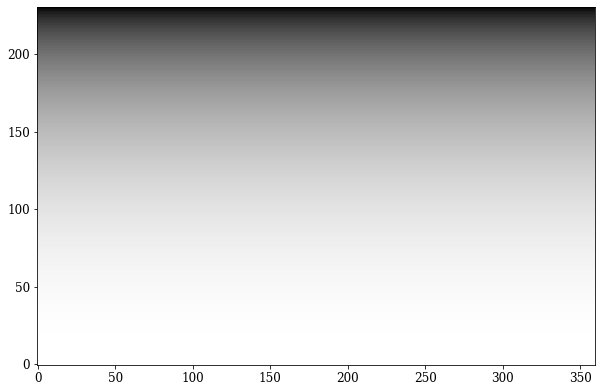

In [23]:
polar_fit_mask = limb_darkening_mask_calculation(list_of_medians, ld_fit, polar_img.shape)
show_image(polar_fit_mask)

$\textbf{Transformation from polar to cartesian coordinates}$

In [14]:
#převod masky do kartézských souřadnic, oblasti za okrajem disku vyplnit asi??? borderVal???
def transform_to_cartesian(mask, hough_res, mean_value):
    """
    Transform limb darkening mask from polar coordinates to cartesinan coordinates.
    
    Parameters
    ----------
    mask: ndarray
        Calculated mask of limb darkening in polar coordinates.
    hough_res: array
        Contain  results from circle hough transform. Image edge map, 
        coordinates x and y of solar disc center and solar disc radius.
    mean_value: integer
        Value for background surrounding solar disc, taken from mean_array 
        computed earlier with function get_mean(image, radius, center).
        
    Returns
    -------
    limb_darkening_mask: ndarray
        Image of limb darkening mask in cartesian coordinates 
        with defined border value outside the solar disc.
        
    """
    edges, cx, cy, radius = hough_res
         
    #do borderVal dát hodnotu z get_mean()
    limb_darkening_mask = polarTransform.convertToCartesianImage(mask.T, center = (cx, cy), border='constant',
                                                                 borderVal=mean_value, imageSize=sol_img_small.shape)
    #maska pro úpravy snímků s původní velikostí!!!
    #limb_darkening_mask_big = polarTransform.convertToCartesianImage(mask.T, center = (CX, CY), border='constant',
    #                                                            borderVal=600.0, imageSize=sol_img.shape)
    
    return limb_darkening_mask[0]#, limb_darkening_mask_big[0]

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (512, 512) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  float32


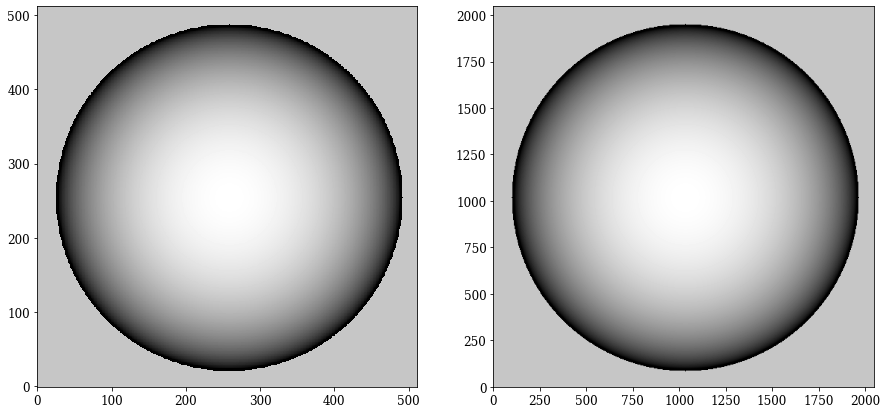

In [25]:
#Možná udělat tak, že upravím rozsah intezit masky tak, aby to bylo mezi 1 - něco, lepší pro dělení níže
limb_darkening_mask = transform_to_cartesian(polar_fit_mask, hough_res, mean_array[0][0])
#limb_darkening_mask_big = np.array(Image.fromarray(limb_darkening_mask).resize(sol_img.T.shape, Image.BILINEAR))
limb_darkening_mask_big = size_reduction(limb_darkening_mask, 1/4)
show_images(limb_darkening_mask, limb_darkening_mask_big)

In [15]:
def limb_darkening_removal(image, mask, mean_value):
    """
    Remove limb darkening from solar image.
    
    Paramaters
    ----------
    image: ndarray
        Solar image expected.
    mask: ndarray
        Mask calculated from limb darkening function expected.
    mean_value: integer
        Arithmetic mean calculated from mask expected.
    
    Returns
    -------
    sol_img_nld: ndarray
        Solar image with no limb darkening at the best case.
        
    """    
    sol_img_nld = (image / mask) * mean_value
 
    return sol_img_nld

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (512, 512) , Image1 data type:  int32
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (512, 512) , Image2 data type:  float64


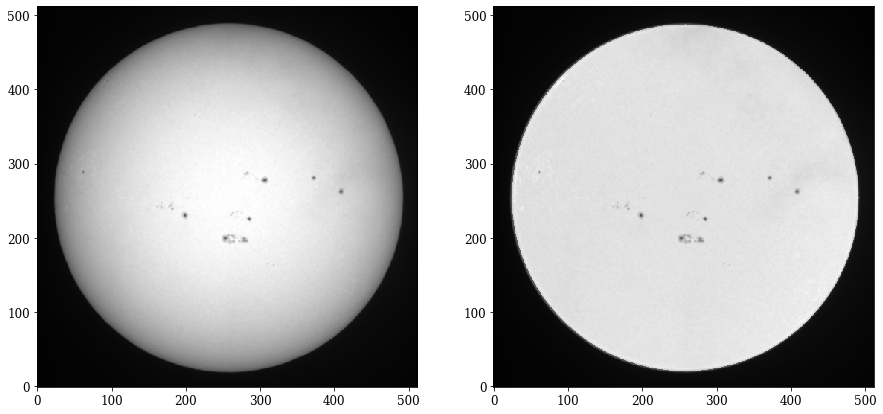

In [27]:
sol_img_nld = limb_darkening_removal(sol_img_small, limb_darkening_mask, mean_array[0][0])
sol_img_nld_big = limb_darkening_removal(sol_img, limb_darkening_mask_big, mean_array[0][0])
show_images(sol_img_small, sol_img_nld)

$\large\textbf{Elimination of non-radial variation}$

Valentina Zharkova's algorithm. 

We reduce original image size. Median from reduced image (with large structuring element) and mean of median are computed. Than normalised image is computed as follows:
- substract median filter from the original image, than back to original intensity level (mean median addition)
- now we need to locate pixel corresponding to bright and dark regions, so we define two suitable tresholds
- we find maximum y - value H_M from histogram, the value which has the most pixels (pixels of quiet solar disc)
- we find intensity level V_M corresponding to the most frequent value H_M
- we locate intensity value V1 corresponding to H_M / a1 (V1 < V_M) and V2 corresponding to H_M / a2 (V2 > V_M)
- a1, a2 are constants (which are not specified in original article)
- we create the set S, this set contains values out of the range [V1, V2]
- than we replace values from set S with their corresponding values from median filter, this step eliminates too dark and too bright places by replacing them with median values -> sol_img_small_norm[S] = median_mask[S]
- now we have image normalised in the first step with median filter with large structuring element and with solar features replaced with median values
- from this normalised image we compute median filter with smaller structuring element (half of the size) 
- now we enlarge this median filter to the original image size
- we substract this median filter from original image and add newly computed mean median array to fix background intensity level
- DONE

In [28]:
#nezapomenout: pořadí souřadnic je správně asi takto: [y,x]!!!

In [16]:
def first_median_filtering(image, radius, center):
    """
    Fuller algorithm (or Zharkova?). Normalised solar image is computed as follows:
    normalised solar image = input image - median mask + arithmetic mean of the median mask
    
    Paramaters
    ----------
    image: ndarray
        Solar image with no limb darkening.
    radius: integer
        Solar disc radius.
    center: list with two integer values
        Solar disc center coordinates.
    
    Returns
    -------
    sol_img_small_norm: ndarray
        Solar image with large scale non-radial variations removed.
    (median_mask: ndarray
        Median mask computed with large structuring element from input solar image. SE needs odd number of pixels.)
    
    """       
    median_mask = median(image, square(49), behavior='ndimage', mode='wrap') #je třeba používat lichý počet px!
    mean_median_mask = get_mean(median_mask, radius, center) 
    cx, cy = center
    
    sol_img_small_norm = np.copy(image)
    width, height = image.shape
    for x in range(0, width):
        for y in range(0, height):
            if (cx - x)**2 + (cy - y)**2 <= (radius)**2:
                sol_img_small_norm[y,x] = sol_img_nld[y,x] - median_mask[y,x] + mean_median_mask[y,x]
  
    return sol_img_small_norm, median_mask 

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (512, 512) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (512, 512) , Image2 data type:  float64


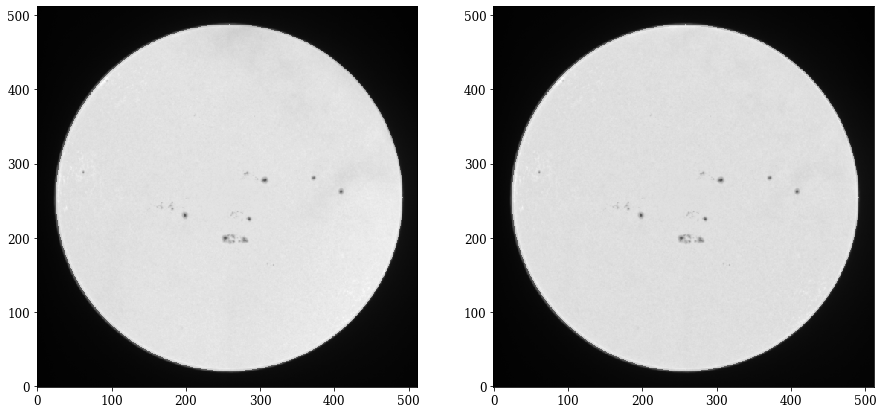

In [30]:
sol_img_small_norm, median_mask = first_median_filtering(sol_img_nld, radius, [cx, cy])
show_images(sol_img_nld, sol_img_small_norm)

In [17]:
def solar_feature_removal(image, median_mask):
    """
    Takes the input image which is after first median filtering and calculates two suitable thresholds for
    replacing pixel values corresponding to the solar features by values from median mask at the same position. 
    
    Paramaters
    ----------
    image: ndarray
        Solar disc after first median filtering (median filter with large structure element).
    median_mask: ndarray
        Median mask computed from solar image with no limb darkening using large SE.
    
    Returns
    -------
    V_M: integer
        The most frequent intensity value on the solar disc.
    V1: integer
        Threshold value V1 < V_M for removing dark features from solar disc.
    V2: integer
        Threshold value V2 > V_M for removing bright features from solar disc.
    no_feature_img:ndarray
        Image with solar feature removed using thresholds V1 & V2.
        
    """    
    #Pro určení počtu binů
    min_val = np.amin(np.amin(image))
    max_val = np.amax(np.amax(image))
    print('Minimum and maximum values in list: ', min_val, max_val)

    #y je seznam četností, amax najde největší četnost
    plt.rcParams['figure.figsize'] = [10, 10]
    y, x, _ = plt.hist(image.flatten(), histtype='step', bins=int(max_val) - int(min_val), log=True)

    #zde pomocí Otsuova prahování odstranění pvrvní části bimodálního histogramu, která odpovídá oblasti
    #mimo disk!!!!
    thresh = threshold_otsu(image)
    #x_beginning = np.where(x == thresh)
    idx = (np.abs(x - thresh)).argmin()
    #ze seznamu y odstranit vše, co je menší jako x = thresh!
    print('Práh pro odstranění pozadí ze seznamů četností a intenzit: ', thresh)
    print('Hodnota intenzity, od které bude vše menší odstraněno ze seznamu intenzit: ', x[idx])
    x = x[idx:]
    y = y[idx:]
    # H_M je nejvyšší četnost v histogramu  (osa y), V_M je odpovídající hodnota na ose x
    H_M = np.amax(y)
    H_M_position = np.where(y == H_M) # H_M_position je index v příslušném poli y, kde se nachází H_M, nefunguje pro BBSO
    ### H_M_position je tuple of tuples/arrays, H_M_position[0] je pole s pozicí maxim, (H_M_position[0])[0] už číslo:
    H_M_position = (H_M_position[0])[0] 
    V_M = x[H_M_position] # hodnota pixelu s největší četností, resp. odpovídající 'bin'

    print('Maximum histogram frequency H_M: ', H_M)
    print('Position of H_M in list:  ', H_M_position)
    print('Intensity value corresponding to H_M: ', V_M)
    
    ### Nyní chceme najít hodnoty (V1 odpovídá H_M / a1) < V_M a (V2 odpovídá H_M / a2) > V_M; co jsou a1 a a2????
    #odhad konstant H1, H2 (asi a1 a a2 u Zharkové), hledám v polovině logaritmické křivky
    a1 = 100
    a2 = 100
    const_estimate1 = H_M / a1
    const_estimate2 = H_M / a2
    print('Estimated frequences H1 and H2 using constant a1, a2: ', const_estimate1, ', ', const_estimate2)

    #hledat od vrcholu, od vrcholu doleva a doprava...
    H1_position = (np.abs(y[:H_M_position][::-1] - const_estimate1)).argmin() #hledám hodnotu zleva, nejblíž k odhadované kostantě
    H2_position = (np.abs(y[H_M_position:] - const_estimate2)).argmin() #hledám hodnotu zprava, nejblíž k odhadované kostantě
    H1_position = H_M_position - H1_position - 1
    H2_position = H_M_position + H2_position
    print('Found frequencies H1 and H2: ', y[H1_position], ', ', y[H2_position])
    print('Positions of nearest frequency values to H1, H2: ', H1_position, ', ', H2_position)

    V1 = x[H1_position]
    V2 = x[H2_position]
    print('Intensity value V_M, corresponding to H_M: ', V_M, ', ', H_M)
    print('Intensity values V1, V2 corresponding to H1, H2 (sunspots, filaments, flares, plages): ', V1, ', ', V2)
    ### vše, co je venku z rozsahu V1 - V2 (<0,V1) U (V2, 512>), nahradíme v sol_img_small_norm pixely z median_mask
    #na obdélníkovém snímku nefunguje..
    no_feature_img = np.copy(image)
    width, height = no_feature_img.shape

    #tady pozor! Pro snímek z HVM jsem musela obrátit height a width v cyklech, zkusit znovu na KSO!!!
    for x in range(0, height):
        for y in range(0, width):
            if (no_feature_img[y,x] < V1 or no_feature_img[y,x] > V2):
                no_feature_img[y,x] = median_mask[y,x]           
    
    return V_M, V1, V2, no_feature_img

Minimum and maximum values in list:  5.0 1019.8560508825835
Práh pro odstranění pozadí ze seznamů četností a intenzit:  462.8745073317906
Hodnota intenzity, od které bude vše menší odstraněno ze seznamu intenzit:  462.3858138593103
Maximum histogram frequency H_M:  8662.0
Position of H_M in list:   425
Intensity value corresponding to H_M:  887.7446123061525
Estimated frequences H1 and H2 using constant a1, a2:  86.62 ,  86.62
Found frequencies H1 and H2:  86.0 ,  86.0
Positions of nearest frequency values to H1, H2:  398 ,  470
Intensity value V_M, corresponding to H_M:  887.7446123061525 ,  8662.0
Intensity values V1, V2 corresponding to H1, H2 (sunspots, filaments, flares, plages):  860.7218180518825 ,  932.7826027299358
Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (512, 512) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (512, 512) , Image2 data type:  float64


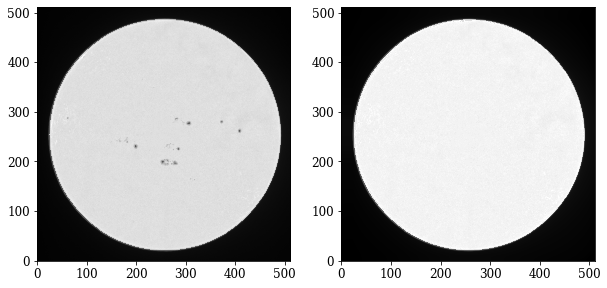

In [32]:
V_M, V1, V2, no_feature_img = solar_feature_removal(sol_img_small_norm, median_mask)

show_images(sol_img_small_norm, no_feature_img)

In [18]:
def nonradial_variation_removal(no_feature_image, original_image, center, radius_big, sol_img_nld_big):
    """
    Takes input image with solar feature removed, creates median mask from this image with 
    smaller structuring element as previously (half of the size of the first median filter 
    SE) and follows the same procedure as in first median filtering. Returns normalised 
    image with original solar image size.
    
    Paramaters
    ----------
    no_feature_image: ndarray
        Solar image with solar features removed.
    original_image: ndarray
        Solar image with original image size.
    center: list of two integer values
        Solar disc center coordinates calculated from original image (original size).
    radius_big: integer
        Solar disc radius calculated from original image (original size).
    sol_img_nld_big: ndarray
        Solar image with no limb darkening and with original solar image size.
    
    Returns
    -------
    sol_img_norm: ndarray
        Normalised solar image - with non-radial variations removed.
    median_mask_second_big: ndarray
        Median mask computed from image with solar features removed and with smaller
        structuring element (half of the size of SE from first median filtering).
    """       
    #když použiju SE disk, vypíše error!!!
    cx_big, cy_big = center
    median_mask_second = median(no_feature_image, square(25), behavior='ndimage', mode='wrap')
    median_mask_second_big = np.array(Image.fromarray(median_mask_second).resize((original_image.T.shape), 
                                                                                 Image.BILINEAR))
    
    show_images(median_mask_second, median_mask_second_big) #tohle časem smazat
    
    mean_median_mask_second_big = get_mean(median_mask_second_big, radius_big, [cx_big, cy_big])        
   
    #aplikujeme vzorec : sol_img_norm = sol_img - SM + mean(SM)
    sol_img_norm = np.zeros_like(original_image)#np.copy(sol_img_nld_big)
    width, height = sol_img_nld_big.shape

    for x in range(0, height):
        for y in range(0, width):
            if (cx_big - x)**2 + (cy_big - y)**2 <= radius_big**2:
                sol_img_norm[y,x] = (sol_img_nld_big[y,x] - median_mask_second_big[y,x] + 
                                     mean_median_mask_second_big[y,x])
            
    return sol_img_norm, median_mask_second_big

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (512, 512) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  float32


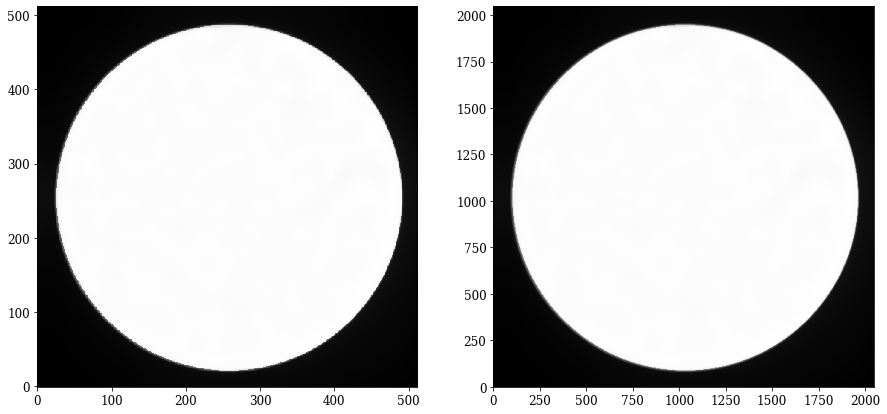

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  int16


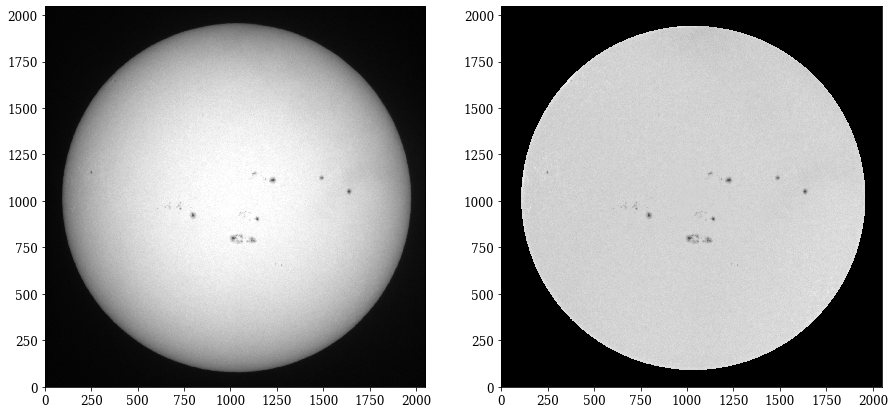

In [34]:
sol_img_norm, median_mask_second_big = nonradial_variation_removal(no_feature_img, sol_img, [cx_big, cy_big],
                                                                   radius_big, sol_img_nld_big)

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  int16


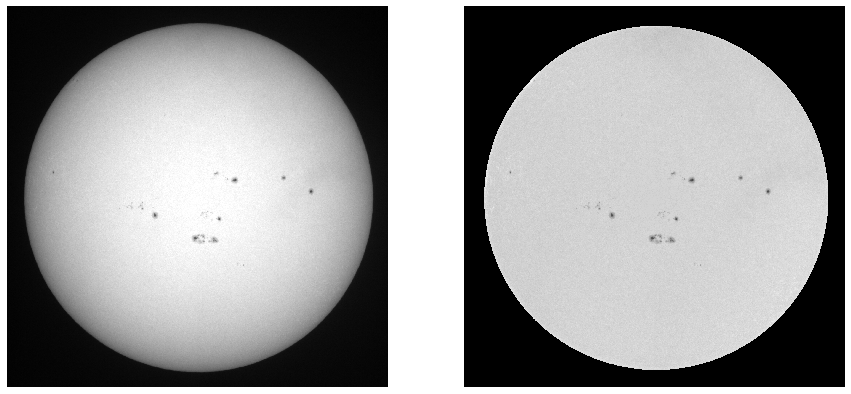

In [36]:
show_images(sol_img, sol_img_norm)

$\large\textbf{Globální prahování}$

plt.rcParams['figure.figsize'] = [10, 10]
histogram = plt.hist(sol_img.flatten(), histtype='step', bins=int(max_val) - int(min_val), 
                      range=(350, 700), log=True)

plt.rcParams['figure.figsize'] = [10, 10]
histogram = plt.hist(sol_img_norm.flatten(), histtype='step', bins=int(max_val) - int(min_val), 
                     range=(350, 700), log=True)

Image type:  <class 'numpy.ndarray'> , Image shape:  (2048, 2048) , Image data type:  int16


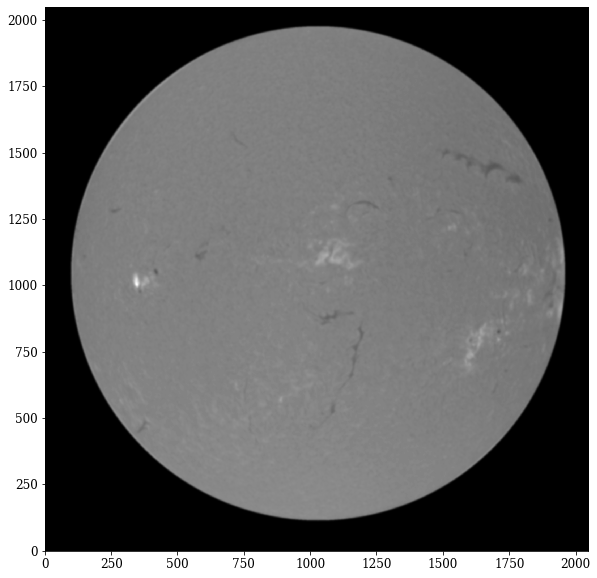

In [37]:
gaussian_img = ndimage.gaussian_filter(sol_img_norm, 3)
show_image(gaussian_img)

Minimum and maximum values in list:  0 1433


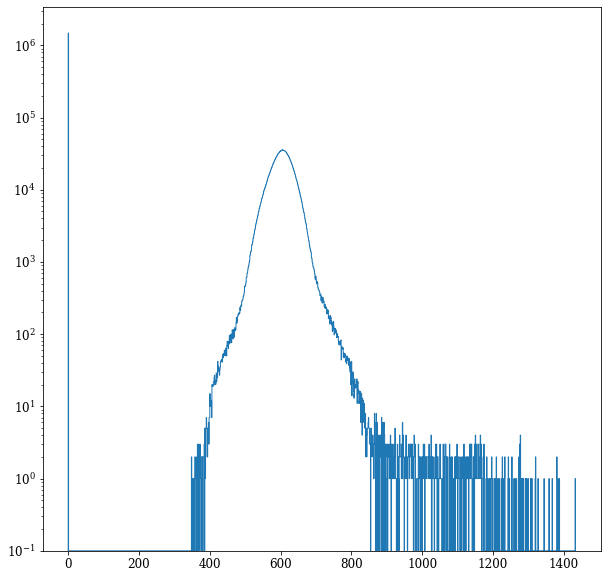

In [38]:
# pro vytvoření histogramu
min_val = np.amin(np.amin(sol_img_norm))
max_val = np.amax(np.amax(sol_img_norm))
print('Minimum and maximum values in list: ', min_val, max_val)

plt.rcParams['figure.figsize'] = [10, 10]
histogram = plt.hist(sol_img_norm.flatten(), histtype='step', bins=int(max_val) - int(min_val), log=True)

In [19]:
###Globální prahování
def global_thresholding(image, mean_array):
    
    width, height = image.shape
    thresh = mean_array[0][0]
    binary = np.empty(image.shape)
    for x in range(0, height):
        for y in range(0, width):
            if (cx_big - x)**2 + (cy_big - y)**2 <= radius_big**2 and image[y,x] > thresh:
                binary[y,x]=True
            else:
                binary[y,x]=False
            
    print('Práh: ', thresh)
    
    return binary

In [40]:
binary = global_thresholding(gaussian_img, mean_array)

Práh:  604.0


Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  float64


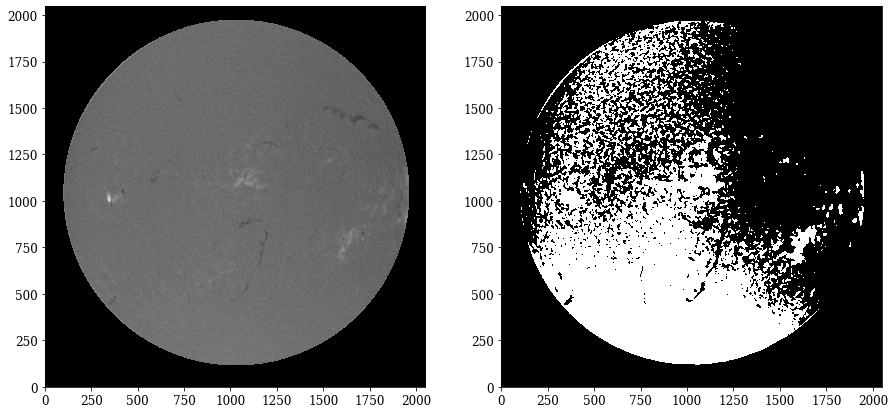

In [41]:
show_images(sol_img_norm, binary)

$\large\textbf{Segmentace skvrn a filamentů}$

In [31]:
from skimage.filters import threshold_local
from skimage.morphology import binary_erosion
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects

In [21]:
#lokální prahování pro tmavé oblasti narušují příliš světlé oblasti, funkce threshold_local pak totiž
#označuje oblasti kolem světlých pláží a erupcí jako detekované tmavé oblasti, proto je třeba
#světlé oblasti eliminovat, nejspíše použitím prahu V2 z algoritmu Zharkové
def dark_feature_extraction(image, median_mask, center, radius_big, mean_value):
    """
    Uses local thresholding and mathematical morphology to extract dark features from solar disc.
    
    Paramaters
    ----------
    image: ndarray
        Normalised solar image (with limb darkening and non-radial variations removed).
    median_mask: ndarray
        Median mask computed from image with solar features removed and with smaller
        structuring element (half of the size of SE from first median filtering).
    center: list with two integer values
        Solar disc center coordinates computed from original image (original size).
    radius_big: integer
        Solar disc radius computed from original image (original size).
    
    Returns
    -------
    dark_experimental_img: ndarray
        Solar image with too bright regions removed from solar disc (using V2 threshold 
        from Zharkova algorithm).
    dark_binary_local: ndarray
        Binary image obtained from local thresholding.
    dark_binary_local_nl:
        Binary image obtained from local thresholding with solar limb assign to
        the background.
    dark_eroded:
        Binary image calculated with binary morphological erosion operator.
    dark_reconstructed:
        Eroded binary image morphologically reconstructed.
    dark_without_small_objects:
        Binary image with too small object removed.
    
    """
    
    cx_big, cy_big = center
    dark_experimental_img = np.copy(image)
    width, height = dark_experimental_img.shape
    for x in range(0, height):
        for y in range(0, width):
            if (dark_experimental_img[y,x] > V2):
                dark_experimental_img[y,x] = median_mask[y,x]

    #gaussovský filtr odstraní mnoho šumu! Ale taky naruší detekci slabých útvarů...
    #bacha na sigma!
    dark_experimental_img = ndimage.gaussian_filter(dark_experimental_img,3) 
    #nebo nejprve zaostřit a pak gaussovsky rozmazat a eliminovat tak šum:
    #dark_experimental_img = ndimage.gaussian_filter(dark_experimental_img + 
    #                                                ndimage.gaussian_laplace(dark_experimental_img,3),3)
    #show_image(dark_experimental_img)
    
    #prahování pomocí "posouvacího okna", z nějž je spočten medián a s touto hodnotou je porovnáván zkoumaný pixel
    #Bacha, někdy kromě filamentů hledá oblasti, které se kvůli světlých regionům v blízkosti jeví tmavé! 
    #Je třeba vhodně zvolit parametry anebo přiliš světlé regiony odstranit... DONE (V2 podmínka)
    image_cp = np.copy(dark_experimental_img) 
    #jaká bude vhodná velikost okna? Určitě procentuálně, ale jaká? A offset? Také na něm hodně záleží!
    block_size = 95  
    #Offset se zatím zdá být vhodný 5% z průměrné intenzity disku: get_mean(sol_img_small)
    offset_val = np.round(5 * mean_value / 100)
    local_thresh = threshold_local(image_cp, block_size, method='gaussian', offset=offset_val)
    dark_binary_local = image_cp < local_thresh

    #show_images(sol_img_norm, dark_binary_local)
    
    #odstranění okraje disku z výsledku lokálního prahování, jak velkou část disku obětuju? Prahování to vzalo 
    #docela #zeširoka.
    dark_binary_local_nl = np.copy(dark_binary_local)
    width, height = dark_binary_local_nl.shape
    for x in range(0, height):
        for y in range(0, width):
            if ((cx_big - x)**2 + (cy_big - y)**2 > (radius_big - 20)**2):
                dark_binary_local_nl[y,x] = False
  
    #Eroze. Jak velký strukturní element?  
    selem = square(5)
    dark_eroded = binary_erosion(dark_binary_local_nl, selem)
    
    #Rekonstrukce. ak velký strokturní element? Stejně jako u eroze nebo jiný?
    dark_reconstructed = reconstruction(dark_eroded, dark_binary_local_nl, method='dilation', selem=square(7))
    
    #Odstranění malých objektů. Je potřeba prozkoumat, jak malé objekty můžu odstranit, abych 
    #zase neodstraňovala např. sluneční skvrny, žejo...
    dark_reconstructed_cp = np.copy(dark_reconstructed)
    dark_binary_reconstructed = dark_reconstructed_cp > 0
    dark_without_small_objects = remove_small_objects(dark_binary_reconstructed, 60, connectivity=8)
    
    return (dark_experimental_img, dark_binary_local, dark_binary_local_nl, dark_eroded, 
            dark_reconstructed, dark_without_small_objects)

In [44]:
dark_result = dark_feature_extraction(sol_img_norm, median_mask_second_big, [cx_big, cy_big], radius_big, 
                                      mean_array[0][0])
dark_experimental_img = dark_result[0]
dark_binary_local = dark_result[1]
dark_binary_local_nl = dark_result[2]
dark_eroded = dark_result[3]
dark_reconstructed = dark_result[4]
dark_without_small_objects = dark_result[5] 

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


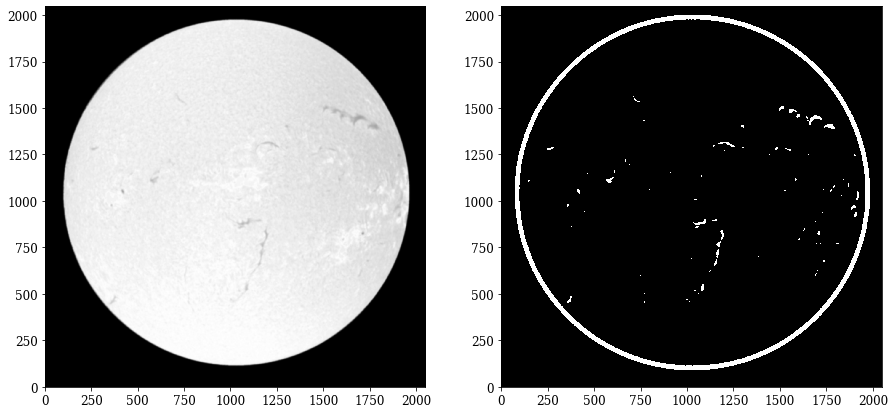

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  bool
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


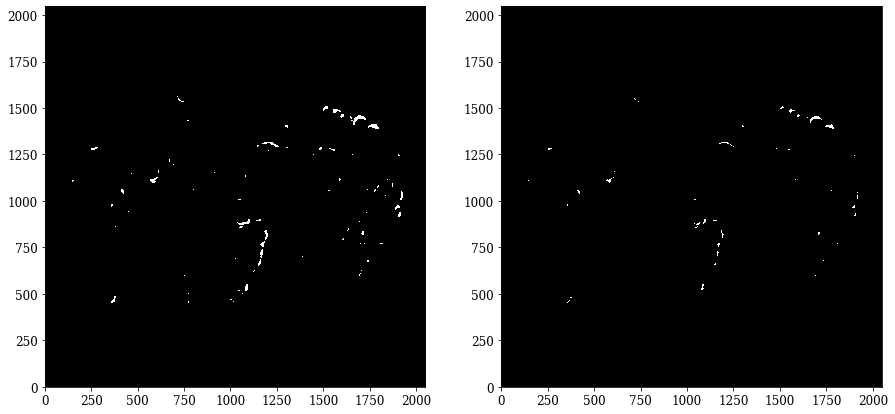

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


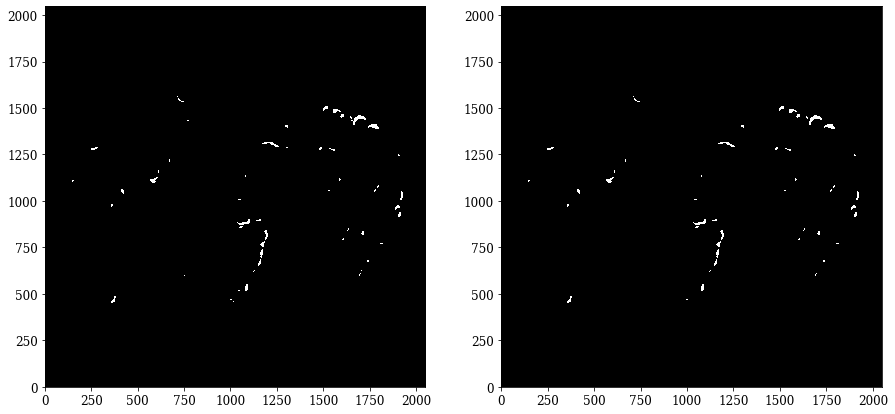

In [45]:
show_images(dark_experimental_img, dark_binary_local)
show_images(dark_binary_local_nl, dark_eroded)
show_images(dark_reconstructed, dark_without_small_objects)

$\large\textbf{Segmentace pláží a erupcí}$

In [22]:
#lokální prahování pro světlé oblasti narušují příliš tmavé oblasti, funkce threshold_local pak totiž
#označuje oblasti kolem tmavých skvrn a filamentů jako detekované světlé oblasti, proto je třeba
#tmavé oblasti eliminovat, nejspíše použitím prahu V1 z algoritmu Zharkové
def bright_feature_extraction(image, median_mask, center, radius_big, mean_value): 
    """
    Uses local thresholding and mathematical morphology to extract bright features from solar disc.
    
    Paramaters
    ----------
    image: ndarray
        Normalised solar image (with limb darkening and non-radial variations removed).
    median_mask: ndarray
        Median mask computed from image with solar features removed and with smaller
        structuring element (half of the size of SE from first median filtering).
    center: list with two integer values
        Solar disc center coordinates computed from original image (original size).
    radius_big: integer
        Solar disc radius computed from original image (original size).
    
    Returns
    -------
    bright_experimental_img: ndarray
        Solar image with too dark regions removed from solar disc (using V1 threshold 
        from Zharkova algorithm).
    bright_binary_local: ndarray
        Binary image obtained from local thresholding.
    gright_binary_local_nl:
        Binary image obtained from local thresholding with solar limb assign to
        the background.
    bright_eroded:
        Binary image calculated with binary morphological erosion operator.
    bright_reconstructed:
        Eroded binary image morphologically reconstructed.
    bright_without_small_objects:
        Binary image with too small object removed.
    
    """
    cx_big, cy_big = center
    bright_experimental_img = np.copy(image)
    width, height = bright_experimental_img.shape
    for x in range(0, height):
        for y in range(0, width):
            if (bright_experimental_img[y,x] < V1):
                bright_experimental_img[y,x] = median_mask[y,x]
    
    bright_experimental_img = ndimage.gaussian_filter(bright_experimental_img,3)
 
    #Lokální prahování pomocí "posouvacího okna", z nějž je spočten medián a s touto 
    #hodnotou je porovnáván zkoumaný pixel. 
    image_cp = np.copy(bright_experimental_img)
    block_size = 95
    #Offset se zatím zdá být vhodný 5% z průměrné intenzity
    offset_val = np.round(5 * mean_value / 100)
    local_thresh = threshold_local(image_cp, block_size, method='gaussian', offset=-offset_val)
    bright_binary_local = image_cp > local_thresh
   
    #odstranění okraje disku ze snímku po lokálním prahování
    bright_binary_local_nl = np.copy(bright_binary_local)
    width, height = bright_binary_local_nl.shape
    for x in range(0, height):
        for y in range(0, width):
            if ((cx_big - x)**2 + (cy_big - y)**2 > (radius_big - 30)**2):
                bright_binary_local_nl[y,x] = False
   
    #Eroze.
    selem = square(5)
    bright_eroded = binary_erosion(bright_binary_local_nl, selem)

    #Rekonstrukce.
    #selem = square(6)
    bright_reconstructed = reconstruction(bright_eroded, bright_binary_local_nl, method='dilation', selem=square(7))
    
    #Odstranění malých objektů
    bright_reconstructed_cp = np.copy(bright_reconstructed)
    bright_binary_reconstructed = bright_reconstructed > 0
    bright_without_small_objects = remove_small_objects(bright_binary_reconstructed, 100, connectivity=8)

    return (bright_experimental_img, bright_binary_local, bright_binary_local_nl, 
            bright_eroded, bright_reconstructed, bright_without_small_objects)

In [47]:
bright_result = bright_feature_extraction(sol_img_norm, median_mask_second_big, [cx_big, cy_big], radius_big, 
                                          mean_array[0][0])
bright_experimental_img = bright_result[0]
bright_binary_local = bright_result[1]
bright_binary_local_nl = bright_result[2]
bright_eroded = bright_result[3]
bright_reconstructed = bright_result[4]
bright_without_small_objects = bright_result[5]

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


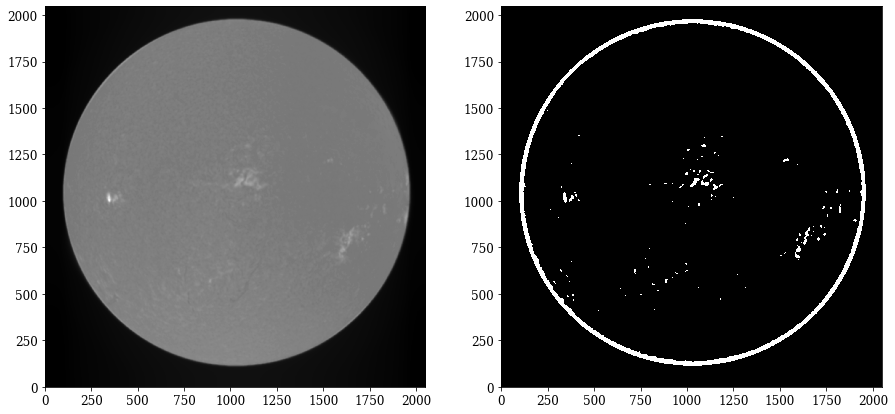

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  bool
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


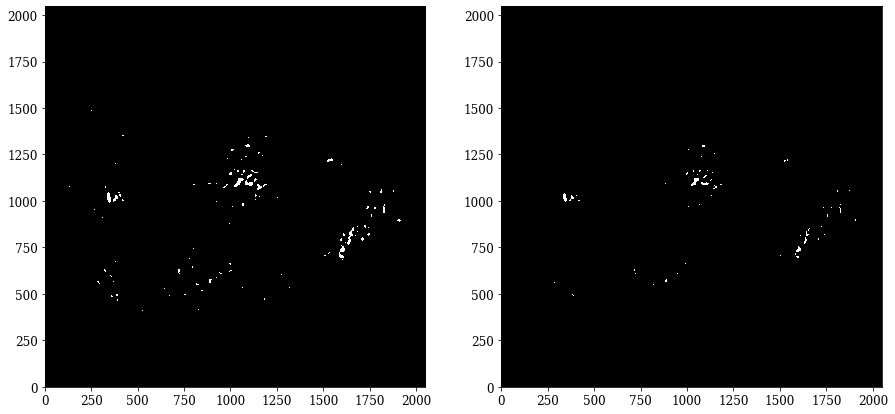

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  float64
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  bool


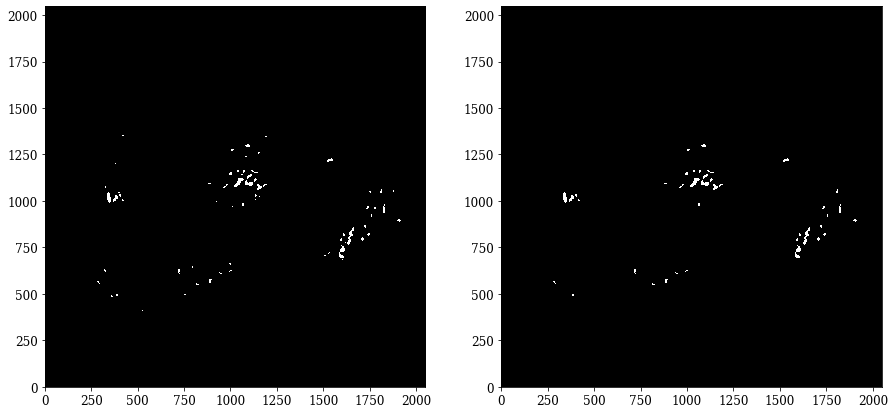

In [48]:
show_images(bright_experimental_img, bright_binary_local)
show_images(bright_binary_local_nl, bright_eroded)
show_images(bright_reconstructed, bright_without_small_objects)

$\large\textbf{Regions labelling before region growing method application}$

Výstup z dark_feature_extraction() a bright_feature_extraction() by byly dva binární snímky. Ty budou vstupem do další funkce, která bude řešit zaplnění děr, růst oblastí a labelling. Případně spojení očividných rozpojených filamentů? 
Názvy funkcí nejspíše:
- dark_feature_labelling(): return bright_feature_labels
- bright_feature_labelling(): return bright_feature_labels

In [32]:
from skimage import measure #je potřeba pro labelling
from skimage.measure import regionprops #je potřeba pro měření vlastností v jednotlivých regionech

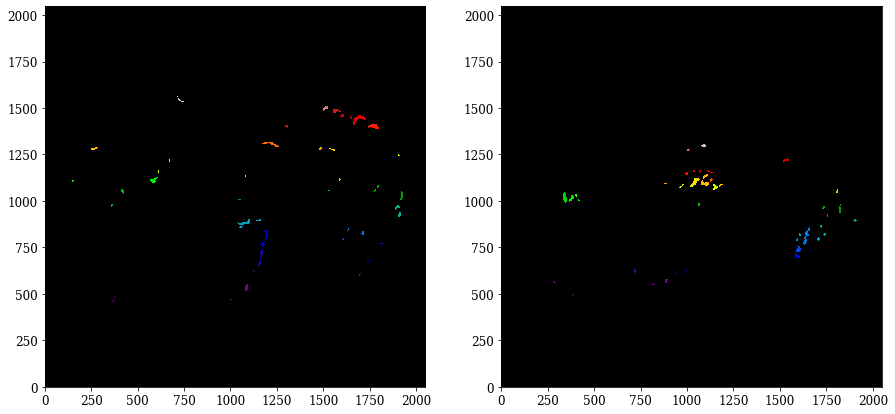

In [50]:
#Značkování oblastí
dark_feature_labels = measure.label(dark_without_small_objects, background=0, return_num=False)
bright_feature_labels = measure.label(bright_without_small_objects, background=0)
#print(dark_feature_labels[1])

#Zobrazení tmavých a světlých označkovaných oblastí
plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(1, 2, 1)
plt.imshow(dark_feature_labels, cmap='nipy_spectral', origin='lower')
plt.subplot(1, 2, 2)
plt.imshow(bright_feature_labels, cmap='nipy_spectral', origin='lower')
plt.show()

In [51]:
# Měření vlastností označkovaných oblastí (pro ověření potřebnosti růstu oblastí!)
dark_props = regionprops(dark_feature_labels, intensity_image=sol_img_norm)
bright_props = regionprops(bright_feature_labels, intensity_image=sol_img_norm)

(467.6900212314225, 367.9872611464968)
(494.1304347826087, 387.1304347826087)
Kruhovost skvrny:  0.4345198153344792
Kompaktnost skvrny:  1.3183623406855631
Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (41, 32) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (17, 16) , Image2 data type:  int16


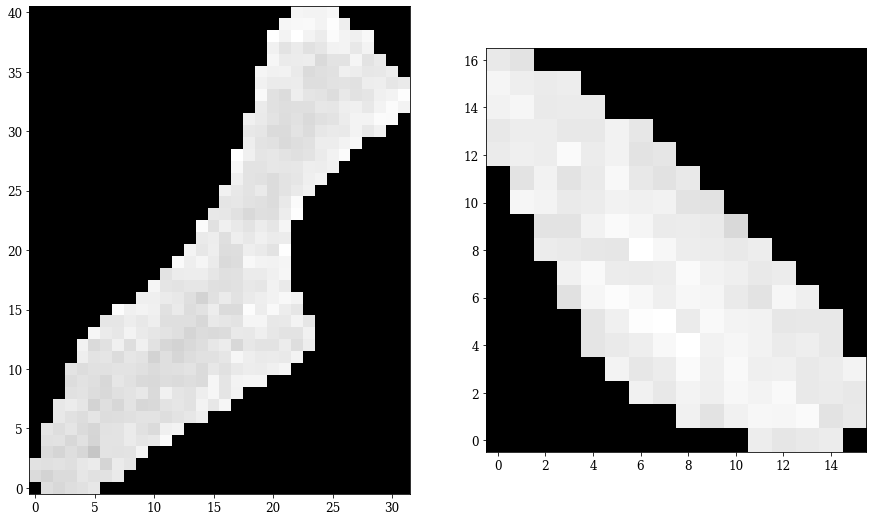

In [52]:
# Zde možný výpis vlastností, které ukáží, zda je třeba růst či spojování oblastí
# Tady bych také dala spojení rozdrobených filamentů, regiony, které budou mít podobnou 
# průměrnou intenzitu, sklon a budou u sebe blízko, tak je spojit. 
i=0
j=0
print(dark_props[i].centroid)
print(bright_props[j].centroid)

A = dark_props[i].area #bright_props[j].area
P = dark_props[i].perimeter #bright_props[j].perimeter

Circularity = ((4 * np.pi * A) / P**2) #Použitá definice z (Osserman 1978)
Compactness = 4 * np.sqrt(np.pi*A) / P #Compactness, Richardson(1961)
print('Kruhovost skvrny: ', Circularity)
print('Kompaktnost skvrny: ', Compactness)

show_images(dark_props[i].intensity_image, bright_props[j].intensity_image)

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  int16


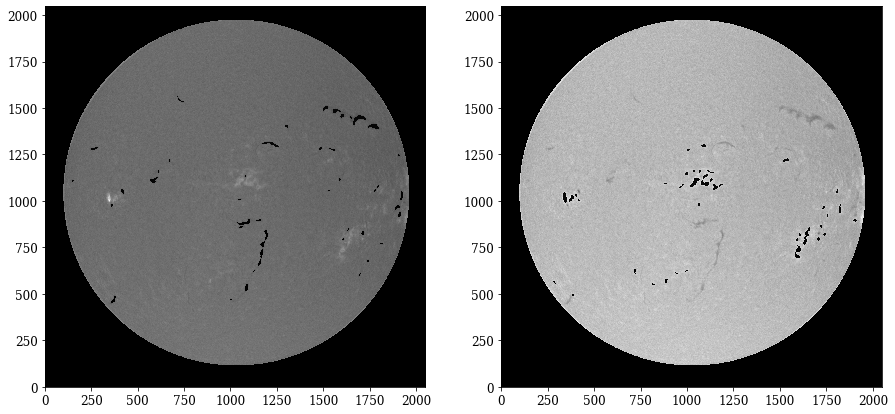

In [53]:
#Značky tmavých struktur zobrazené v původním šedotónovém obrázku
labelled_img_dark = np.copy(sol_img_norm)
width, height = labelled_img_dark.shape
for x in range(0, height):
    for y in range(0, width):
        if (dark_feature_labels[y,x] != 0):
            labelled_img_dark[y,x] = dark_feature_labels[y,x]
            
#Značky světlých struktur zobrazené v původním šedotónovém obrázku
labelled_img_bright = np.copy(sol_img_norm)
width, height = labelled_img_bright.shape
for x in range(0, height):
    for y in range(0, width):
        if (bright_feature_labels[y,x] != 0):
            labelled_img_bright[y,x] = bright_feature_labels[y,x]

show_images(labelled_img_dark, labelled_img_bright)

$\large\textbf{Region growing}$

In [33]:
# Po zkoušce měření vlastností objektů zjištěno, že růst je velmi důležitý! Po něm dostavám smysluplné výsledky,
# růst zaplní děravé oblasti (významné hlavně u skvrn, kde před růstem byla kruhovost 0.3 - 0.4, po něm 0.6  - 0.7),
# ale také u filametů, které hezky zaplní. Některé filamenty byly děravé jak cedník, výsledek měření byl v podstatě 
# k ničemu.

#Růst tmavých oblastí:
dark_regions_grown = np.zeros(dark_without_small_objects.shape)
#region_growing_thresh = mean_array[0][0] #np.round(mean_array[0][0] / 10)
width, height = dark_without_small_objects.shape

#zkontroluje sousedství pixelu, který !=0, když kritérium True, pak přidá sousednímu pixelu stejnou hodnotu do
#dark_regions_grown, sousedy pixelu uloží do stack
def check(x, y, orig_image, grown_array, region_growing_thresh, objects_shade):
    if objects_shade == 'dark':
        if orig_image[y - 1, x - 1] < region_growing_thresh:
            grown_array[y - 1, x - 1] = True
        if orig_image[y, x - 1] < region_growing_thresh:
            grown_array[y, x - 1] = True
        if orig_image[y + 1, x - 1] < region_growing_thresh:
            grown_array[y + 1, x - 1] = True
        if orig_image[y - 1, x] < region_growing_thresh:
            grown_array[y - 1, x] = True
        if orig_image[y + 1, x] < region_growing_thresh:
            grown_array[y + 1, x] = True
        if orig_image[y - 1, x + 1] < region_growing_thresh:
            grown_array[y - 1, x + 1] = True
        if orig_image[y, x + 1] < region_growing_thresh:
            grown_array[y, x + 1] = True
        if orig_image[y + 1, x + 1] < region_growing_thresh:
            grown_array[y + 1, x + 1] = True
    else:
        if orig_image[y - 1, x - 1] >= region_growing_thresh:
            grown_array[y - 1, x - 1] = True
        if orig_image[y, x - 1] >= region_growing_thresh:
            grown_array[y, x - 1] = True
        if orig_image[y + 1, x - 1] >= region_growing_thresh:
            grown_array[y + 1, x - 1] = True
        if orig_image[y - 1, x] >= region_growing_thresh:
            grown_array[y - 1, x] = True
        if orig_image[y + 1, x] >= region_growing_thresh:
            grown_array[y + 1, x] = True
        if orig_image[y - 1, x + 1] >= region_growing_thresh:
            grown_array[y - 1, x + 1] = True
        if orig_image[y, x + 1] >= region_growing_thresh:
            grown_array[y, x + 1] = True
        if orig_image[y + 1, x + 1] >= region_growing_thresh:
            grown_array[y + 1, x + 1] = True
        
#prochází pixely snímku, když najde nenulovou hodnotu,přidá ji do dark_regions_grown a zkontoluje pomocí check okolí
for x in range(0, height):
    for y in range(0, width):
        if (dark_without_small_objects[y,x] != False):
            dark_regions_grown[y,x] = True
            check(x, y, sol_img_norm, dark_regions_grown, mean_array[0][0], 'dark')

#Regionální metoda růstu, růst do prahu V1 (ten asi posunout blíž k V_M), seed binární snímek, mask sol_img_norm
#Ale bacha na okraj disku, ten nejspíše odstranit!!!anebo vyplnit pozadí za okrajem disku průměrnou hodnotou 
#nebo mediánem.

#Růst oblastí světlých :
bright_regions_grown = np.zeros(bright_without_small_objects.shape)
#region_growing_thresh = mean_array[0][0] + 10 #np.round(mean_array[0][0] / 10)
width, height = bright_without_small_objects.shape

#zkontroluje sousedství pixelu, který !=0, když kritérium True, pak přidá sousednímu pixelu stejnou hodnotu do
#dark_regions_grown, sousedy pixelu uloží do stack
#def check(x, y, orig_image, grown_array, region_growing_thresh):
#    if orig_image[y - 1, x - 1] >= region_growing_thresh:
#        grown_array[y - 1, x - 1] = True
#    if orig_image[y, x - 1] >= region_growing_thresh:
#        grown_array[y, x - 1] = True
#    if orig_image[y + 1, x - 1] >= region_growing_thresh:
#        grown_array[y + 1, x - 1] = True
#    if orig_image[y - 1, x] >= region_growing_thresh:
#        grown_array[y - 1, x] = True
#    if orig_image[y + 1, x] >= region_growing_thresh:
#        grown_array[y + 1, x] = True
#    if orig_image[y - 1, x + 1] >= region_growing_thresh:
#        grown_array[y - 1, x + 1] = True
#   if orig_image[y, x + 1] >= region_growing_thresh:
#        grown_array[y, x + 1] = True
#    if orig_image[y + 1, x + 1] >= region_growing_thresh:
#        grown_array[y + 1, x + 1] = True
        
#prochází pixely snímku, když najde nenulovou hodnotu,přidá ji do dark_regions_grown a zkontoluje pomocí check okolí
for x in range(0, height):
    for y in range(0, width):
        if (bright_without_small_objects[y,x] != False):
            bright_regions_grown[y,x] = True
            check(x, y, sol_img_norm, bright_regions_grown, mean_array[0][0] + 10, 'bright')

show_images(dark_experimental_img, bright_experimental_img)            
show_images(dark_without_small_objects, bright_without_small_objects)
show_images(dark_regions_grown, bright_regions_grown)

NameError: name 'dark_without_small_objects' is not defined

Image1 type:  <class 'numpy.ndarray'> , Image1 shape:  (2048, 2048) , Image1 data type:  int16
Image2 type:  <class 'numpy.ndarray'> , Image2 shape:  (2048, 2048) , Image2 data type:  int16


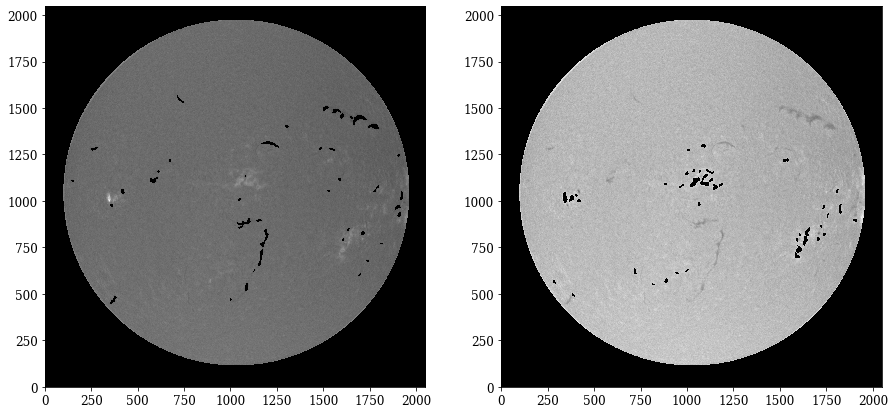

In [55]:
#Značky tmavých struktur po metodě růstu oblastí zobrazené v původním obrázku
labelled_img_dark = np.copy(sol_img_norm)
width, height = labelled_img_dark.shape
for x in range(0, height):
    for y in range(0, width):
        if (dark_regions_grown[y,x] != 0):
            labelled_img_dark[y,x] = dark_regions_grown[y,x]

#Zobrazení světlých oblastí po metodě růstu oblastí v původním šedotónovém snímku
labelled_img_bright = np.copy(sol_img_norm)
width, height = labelled_img_bright.shape
for x in range(0, height):
    for y in range(0, width):
        if (bright_regions_grown[y,x] != 0):
            labelled_img_bright[y,x] = bright_regions_grown[y,x]

show_images(labelled_img_dark, labelled_img_bright)

$\large\textbf{Region labelling after region growing method application}$

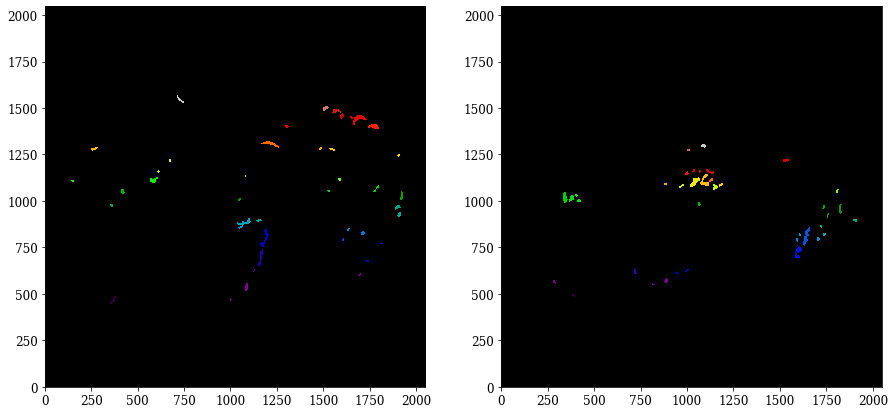

In [56]:
# značkování filamentů a skvrn po růstu oblastí
dark_feature_labels_grown = measure.label(dark_regions_grown, background=0, return_num=False)
#print(dark_feature_labels[1])
# značkování regionů po metodě růstu oblastí
bright_feature_labels_grown = measure.label(bright_regions_grown, background=0, return_num=False)

plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(1, 2, 1)
plt.imshow(dark_feature_labels_grown, cmap='nipy_spectral', origin='lower')
plt.subplot(1, 2, 2)
plt.imshow(bright_feature_labels_grown, cmap='nipy_spectral', origin='lower')
plt.show()

$\large\textbf{Region properties}$

Transformaci jenom na objekty nebo na celé slunce dvě, zachovávající plochy a úhly.
Kdyby jen objekty, najít si střed a promítnout na tečnou rovinu.

In [57]:
# Měření vlastností nalezených regionů po růstu oblastí, 
# např. obsah, obvod, momenty, ale také zobrazí výřez regionu z původního 
# šedotónového obrázku
dark_props_grown = regionprops(dark_feature_labels_grown, intensity_image=sol_img_norm)
bright_props_grown = regionprops(bright_feature_labels_grown, intensity_image=sol_img_norm)

$\large\textbf{More feature properties}$

In [61]:
#def feature_infromation_storage(dark_feature_extracted, bright_feature_extracted)
#    return CSV_table_dark, CSV_table_bright

#přidat projekci pro každý objekt (Postelova projekce)

In [ ]:
# Nezapomenout, že skvrny na okraji budou deformané a spíše eliptické! 
# Buď opravit nějakou 'equal area' projekcí anebo s deformací na okraji počítat

# Circularity = (4 * np.pi * A) / Perimeter**2, používat normální obvod nebo konvexní?

# Níže jsou tytéž vztahy, ničím se neliší, jen očekávaným vstupem. Zde jen pro zobrazení 
# pár výsledků pro srovnání! 

###_Circularity_###
A = dark_props[i].area
P = dark_props[i].perimeter
Circularity = ((4 * np.pi * A) / P**2) #Použitá definice z (Osserman 1978)
Compactness = 4 * np.sqrt(np.pi*A) / P #Compactness, Richardson(1961)
print('Kruhovost skvrny: ', Circularity)
print('Kompaktnost skvrny: ', Compactness)

# stačilo pár pokusů, kruhovost u světlých útvarů nemá smysl

# pro filamenty se hodí parametr curl: length / fibre length (length = box length, fibre length délka páteře)
# fibre length = (perimeter - np.sqrt((perimeter)**2 - 16*area)) / 4
# As the measure of curl decreases, the degree to which they are “curled up” increases.

# Solidity: measures the density of an object
# Solidity = area / convex area
# A value of 1 signifies a solid object, and a value less than 1 will signify an object having an irregular boundary,
# or containing holes.

# Euler number of convex hull?? Or just Euler number?

#Elongation shape factor, odmocnina podílu dvou druhých momentu np.sqrt(i2 / i1)
#dark_props[i].moments

In [63]:
#A = dark_props[i].area
#P = dark_props[i].perimeter
#Circularity = ((4 * np.pi * A) / P**2) #Použitá definice z (Osserman 1978)
#Compactness = 4 * np.sqrt(np.pi*A) / P #Compactness, Richardson(1961)
#print('Kruhovost skvrny: ', Circularity)
#print('Kompaktnost skvrny: ', Compactness)

def circularity(area, perimeter):
    return (4 * np.pi * A) / P**2 #Použitá definice z (Osserman 1978)

def compactness(area, perimeter):
    return 4 * np.sqrt(np.pi*A) / P #Compactness, Richardson(1961)

#Bounding box (min_row, min_col, max_row, max_col). 
#Pixels belonging to the bounding box are in the half-open interval [min_row; max_row) and [min_col; max_col).
#Jak přistupovat k prvkům tuple?
#elongation v rozsahu (0, 1)

#def elongation(bbox): 
#    row_difference = max_row - min_row
#    col_difference = max_col - min_col
#    if row_difference < col_difference:
#        result = row_difference / col_difference
#    else:
#        result = col_difference / row_difference
#    return result

#def relative_intensity(feature_intensity, bacground_disk_intensity):
#     return 100*(feature_intensity / bacground_disk_intensity)

In [64]:
#ukládá informace do slovníku, lze převést do dataFrame
#nefunguje extra_properties=(circularity, compactness,)??? Proč?
dark_table = regionprops_table(dark_feature_labels_grown, intensity_image=sol_img_norm,
                                  properties=('label', 'centroid','perimeter', 'area', 'bbox', 'eccentricity',
                                             'mean_intensity', 'min_intensity', 'max_intensity',
                                             'solidity'), 
                                  separator='-')
dark_data = pd.DataFrame(dark_table)
dark_data.head()
#dark_data.to_csv (r'tables/HWDISC_2014-07-08_06-56-33_0062_final_dark.csv', index = False, header=True)

,label,centroid-0,centroid-1,perimeter,area,bbox-0,bbox-1,bbox-2,bbox-3,eccentricity,mean_intensity,min_intensity,max_intensity,solidity
0,1,467,367,132.988853,612,448,351,491,385,0.950658,548.627451,464.0,602.0,0.790698
1,2,469,1000,43.970563,112,464,995,476,1007,0.451819,572.312500,529.0,603.0,0.918033
2,3,535,1083,113.840620,641,515,1073,557,1093,0.912253,541.581903,469.0,603.0,0.926301
3,4,602,1690,55.213203,150,594,1684,615,1697,0.926064,533.993333,493.0,591.0,0.847458
4,5,623,1123,51.455844,142,615,1116,633,1131,0.935140,562.852113,514.0,601.0,0.940397


In [65]:
bright_table = regionprops_table(bright_feature_labels_grown, intensity_image=sol_img_norm,
                                  properties=('label', 'centroid','perimeter', 'area', 'bbox', 'eccentricity',
                                             'mean_intensity', 'min_intensity', 'max_intensity',
                                             'solidity'),  
                                  separator='-')
bright_data = pd.DataFrame(bright_table)
bright_data.head()
#bright_data.to_csv (r'tables/HWDISC_2014-07-08_06-56-33_0062_final_bright.csv', index = False, header=True)

,label,centroid-0,centroid-1,perimeter,area,bbox-0,bbox-1,bbox-2,bbox-3,eccentricity,mean_intensity,min_intensity,max_intensity,solidity
0,1,494,387,57.698485,208,486,379,505,397,0.888813,680.317308,618.0,738.0,0.967442
1,2,551,817,55.556349,198,546,809,559,829,0.855034,682.424242,635.0,718.0,0.933962
2,3,563,286,57.870058,207,554,279,574,295,0.854319,683.231884,619.0,763.0,0.953917
3,4,570,887,73.698485,370,558,878,584,897,0.779748,713.400000,628.0,861.0,0.963542
4,5,619,720,86.769553,341,604,713,637,730,0.939075,684.868035,620.0,759.0,0.863291


$\large\textbf{Classification}$

In [66]:
#def solar_feature_classificator(CSV_table_dark, CSV_table_bright)
#    return CSV_table_classificated

In [67]:
#tabulka jen jedna pro stejné zvětšení, jasné a tmavé oblasti sloučit do jedné tabulky se stejnou hlavičkou
#pro jeden snímek třeba 4 tabulky, každá pro jiné zvětšení, uživatel si pak vyhodnotí sám, 
#zda je objekt podsegmentován nebo naopak

#lze mít konfigurační soubor, kde budou váhy pro jednotlivé vlastnosti (s jako velkou vahou beru v úvahu kruhovost 
#apod.)

#výstup v heliocentrických souřadnicích

#jeden sloupec skrz kvalitu snímku (projde průměrnou intenzitu v jednotlicých sekcích a porovná)

#pravděpodobnosti se asi budou násobit? A váhy budou exponenty?

#odstranit vše pod úrovní seengu (1 oblouková vteřina)

$\large\textbf{Master function calling all written above}$

In [53]:
def classification(solar_image, file_format, obs_filter, reduction_coefficient, compute_ellipse=False):
    
    #Solar image loading and size reduction
    sol_img = image_loading(solar_image, file_format=file_format)
    sol_img_small = size_reduction(sol_img, reduction_coefficient)
        
    #Solar disk parameters calculation 
    hough_res = circle_hough_transform(sol_img_small)
    edges, cx, cy, radius = hough_res    
    hough_res_big = circle_hough_transform(sol_img)
    edges_big, cx_big, cy_big, radius_big = hough_res_big 
   
    if compute_ellipse==True:
        hough_res_el = ellipse_hough_transform(sol_img_small, radius)
        #Resampling of elliptical solar disc to circular shape doplnit
        
    mean_array = get_mean(sol_img_small, radius, [cx, cy])
    #Image_defects_detection doplnit
    
    #Limb darkening removal
    polar_img = transform_to_polar(sol_img_small, hough_res)    
    list_of_medians = median_of_rows(polar_img)
    max_value, x_data, y_data = data_for_fit(list_of_medians, radius)
    ld_fit = limb_darkening_fit(fit_function, x_data, y_data, list_of_medians)   
    polar_fit_mask = limb_darkening_mask_calculation(list_of_medians, ld_fit, polar_img.shape)    
    cartesian_limb_darkening_mask = transform_to_cartesian(polar_fit_mask, hough_res,
                                                           mean_array[0][0])    
    cartesian_limb_darkening_mask_big = size_reduction(cartesian_limb_darkening_mask, 1/4)    
    sol_img_nld = limb_darkening_removal(sol_img_small, cartesian_limb_darkening_mask, 
                                         mean_array[0][0])    
    sol_img_nld_big = limb_darkening_removal(sol_img, cartesian_limb_darkening_mask_big, 
                                             mean_array[0][0])
    
    #Elimination of non-radial variation
    sol_img_small_norm, median_mask = first_median_filtering(sol_img_nld, radius, [cx, cy])
    V_M, V1, V2, no_feature_img = solar_feature_removal(sol_img_small_norm, median_mask)
    sol_img_norm, median_mask_second_big = nonradial_variation_removal(no_feature_img, sol_img, 
                                                                       [cx_big, cy_big],
                                                                   radius_big, sol_img_nld_big)
    
    #Feature detection
    dark_result = dark_feature_extraction(sol_img_norm, median_mask_second_big, [cx_big, cy_big], 
                                          radius_big, mean_array[0][0])
    dark_without_small_objects = dark_result[5] 
    
    bright_result = bright_feature_extraction(sol_img_norm, median_mask_second_big, [cx_big, cy_big], 
                                              radius_big, mean_array[0][0])
    bright_without_small_objects = bright_result[5] 
   
    #Region growing for dark regions
    dark_regions_grown = np.zeros(dark_without_small_objects.shape)
    #region_growing_thresh = mean_array[0][0] #np.round(mean_array[0][0] / 10)
    width, height = dark_without_small_objects.shape
    for x in range(0, height):
        for y in range(0, width):
            if (dark_without_small_objects[y,x] != False):
                dark_regions_grown[y,x] = True
                check(x, y, sol_img_norm, dark_regions_grown, mean_array[0][0], 'dark')
    
    #Region growing for bright regions
    bright_regions_grown = np.zeros(bright_without_small_objects.shape)
    #region_growing_thresh = mean_array[0][0] + 10 #np.round(mean_array[0][0] / 10)
    width, height = bright_without_small_objects.shape
    for x in range(0, height):
        for y in range(0, width):
            if (bright_without_small_objects[y,x] != False):
                bright_regions_grown[y,x] = True
                check(x, y, sol_img_norm, bright_regions_grown, mean_array[0][0] + 10, 'bright')
    
    #Labelling aftef region growing
    dark_feature_labels_grown = measure.label(dark_regions_grown, background=0, return_num=False)
    bright_feature_labels_grown = measure.label(bright_regions_grown, background=0, return_num=False)
    
    #Dark regions properties to the table
    dark_table = regionprops_table(dark_feature_labels_grown, intensity_image=sol_img_norm,
                                  properties=('label', 'centroid','perimeter', 'area', 'bbox', 'eccentricity',
                                             'mean_intensity', 'min_intensity', 'max_intensity',
                                             'solidity'), 
                                  separator='-')
    dark_data = pd.DataFrame(dark_table)
    
    #Bright regions properties to the table
    #Musím vyřešit hodnotu label! Ve chvíli, kdy se značkuje, tak přeznačkovat tak, aby maximální hodnota +1
    #značky u tmavých oblastí byla první značka u světlých oblastí, jinak se nebude dát dohledávat
    bright_table = regionprops_table(bright_feature_labels_grown, intensity_image=sol_img_norm,
                                  properties=('label', 'centroid','perimeter', 'area', 'bbox', 'eccentricity',
                                             'mean_intensity', 'min_intensity', 'max_intensity',
                                             'solidity'),  
                                  separator='-')
    bright_data = pd.DataFrame(bright_table)
    
    frames = [dark_data, bright_data]
    solar_feature_table = pd.concat(frames, ignore_index=False) #ignore_index=False dokud nevyřeším značkování

    return solar_feature_table

/home/bara/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:479: UserWarning: Downcasting uint16 to int16 without scaling because max value 1374 fits in int16
  return convert(image, np.int16, force_copy)


[1. 1. 1. 1.]


/home/bara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/home/bara/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


TypeError: only size-1 arrays can be converted to Python scalars

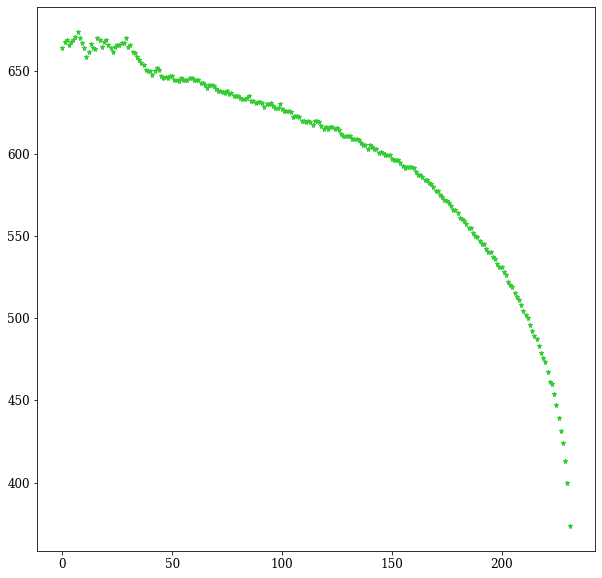

In [54]:
classificated = classification(solar_image='images/kanz_halph_fi_20140808_113238.fts', 
                               file_format='fits', obs_filter='HALPHA', reduction_coefficient=4, 
                               compute_ellipse=False)

In [ ]:
classificated.head()

In [ ]:
#Showing region intensity image and histogram
def show_region(region):
    

In [ ]:
#pro tmavé struktury
i = 0
print(dark_props[i].perimeter, dark_props[i].min_intensity, dark_props[i].centroid)

#pro světlé struktury
j = 0
print(bright_props[j].perimeter, bright_props[j].area, bright_props[j].centroid)

show_images(dark_props[i].intensity_image, bright_props[j].intensity_image) 

In [ ]:
# Histogramy oblastí po metodě růstu oblastí
#chybně detekovaná oblast, očividně příliš jasná, odstraní se podmínkou, že vše, co má průměrnou intenzitu větší jak
#mean_median[0][0], půjde pryč

###_DARK_##
i = 0
min_val = np.amin(np.amin(dark_props[i].intensity_image))
max_val = np.amax(np.amax(dark_props[i].intensity_image))
plt.rcParams['figure.figsize'] = [5, 5]
histogram = plt.hist(dark_props[i].intensity_image.flatten(), histtype='step', bins=int(max_val) - int(min_val), 
                     log=True)

###_BRIGHT_###
j = 0
min_val = np.amin(np.amin(bright_props[j].intensity_image))
max_val = np.amax(np.amax(bright_props[j].intensity_image))
histogram = plt.hist(bright_props[j].intensity_image.flatten(), histtype='step', bins=int(max_val) - int(min_val), 
                     log=True)